2D Poisson equation: $\Delta u = f = u_{xx}+u_{yy} + s^2u$ <br> 
x element of [0,1] <br> y element of [0,1] <br>

Discretized equation with 5-point scheme: $\frac{u^{j}_{i-1}-2u^{j}_{i}+u^{j}_{i+1}}{\Delta x^2} + \frac{u^{j-1}_{i}-2u^{j}_{i}+u^{j+1}_{i}}{\Delta y^2} + s^{2j}_{i}u^{j}_{i}
= \delta(x-0.5,y-0.5) $ <br>

The Dirac delta function is evaluated by setting the center point to the random draw if fidelity is odd or setting the center 2x2 grid to the value if it is even. 

$\Delta y = \Delta x$

-> $(4+\Delta x^2 s^{2j}_{i})u^j_i - u^j_{i-1} - u^{j-1}_i - u^j_{i+1} - u^{j+1}_i = \Delta x^2 \delta(x-0.5,y-0.5)$

https://www.davidpublisher.com/Public/uploads/Contribute/5b5a8959b194f.pdf

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [66]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import time

### Emitter binning

Circle defined on $x \times y = [0,1] \times [0,1]$

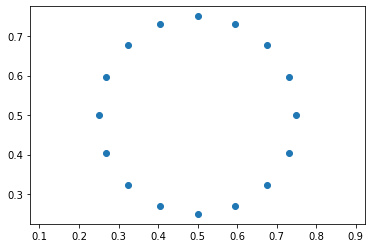

In [69]:
def circle_points(r, n): # Radius, number of points
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    x = r * np.cos(t)
    y = r * np.sin(t)
    circle = np.c_[x, y]
    return circle+0.5

r = 0.25
n = 16
circle = circle_points(r, n)
plt.scatter(circle[:,0], circle[:,1])
plt.axis('equal');

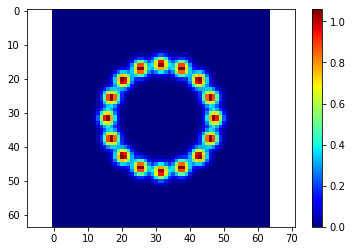

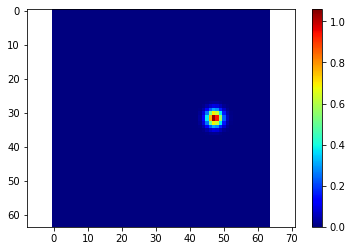

In [70]:
size = 64
sigma_x = 0.025
sigma_y = 0.025

x = np.linspace(0, 1, size)
y = np.linspace(0, 1, size)

x, y = np.meshgrid(x, y)
z = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-((x-0.5)**2/(2*sigma_x**2) + (y-0.5)**2/(2*sigma_y**2))))
vmin = np.min(z); vmax = np.max(z);

z = x*0
z_ls = []
for i in range(len(circle[:,0])):
    z_temp = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-((x-circle[:,0][i])**2/(2*sigma_x**2) + (y-circle[:,1][i])**2/(2*sigma_y**2))))/vmax
    z += z_temp
    z_ls.append(z_temp)
    
vmin_sum = np.min(z); vmax_sum = np.max(z)
plt.imshow(z, cmap='jet', vmin = vmin_sum , vmax = vmax_sum )
plt.axis('equal')
plt.colorbar()
plt.show()

i = 0
z = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-((x-circle[:,0][i])**2/(2*sigma_x**2) + (y-circle[:,1][i])**2/(2*sigma_y**2))))/vmax

plt.imshow(z, cmap='jet', vmin = vmin_sum , vmax = vmax_sum )
plt.axis('equal')
plt.colorbar()
plt.show()

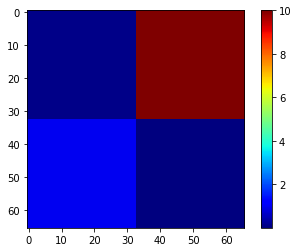

In [71]:
test = np.zeros((size+2,size+2))
test[:33,:33] = 0.1; test[:33,33:] = 10; test[33:,:33] = 1; test[33:,33:] = 0.01
plt.imshow(test, cmap = 'jet')
plt.colorbar()

In [7]:
def helmholtz_solver(fidelity,u_0_x,u_1_x,u_y_0,u_y_1,u_dirac,omega,waterFlat,pressure_init):
    # Modifing fidelity so that the BC are included in the result and its easy to change back
    fidelity = fidelity - 2
    
    x = np.linspace(0,1,fidelity+2)
    dx = x[1]-x[0]
    #y = np.linspace(0,1,fidelity)
    u = np.zeros((fidelity+2,fidelity+2)) # Initial u used to create the b-vector in Ax = b
    if waterFlat == 0:
        c = np.zeros((fidelity+2,fidelity+2)); c[:33,:33] = 0.1; c[:33,33:] = 10; c[33:,:33] = 1.0; c[33:,33:] = 0.01
    else:
        c = np.zeros((fidelity+2,fidelity+2)); c[:,:] = 1.0
        
    s2 = omega**2 / c**2 # Initial u used to create the b-vector in Ax = b
    
    # Initial field
    u[:,:] = pressure_init
    #if fidelity%2 == 0:
    #    u[int((fidelity+2)/2-1):int((fidelity+2)/2+1),int((fidelity+2)/2-1):int((fidelity+2)/2+1)] = u_dirac/4
    #else:
    #    u[int((fidelity+1)/2),int((fidelity+1)/2)] = u_dirac
    
    # BC's
    u[0,:] = u_0_x
    u[-1,:] = u_1_x
    u[:,0] = u_y_0
    u[:,-1] = u_y_1
    

    # 5-point scheme
    A = np.zeros((fidelity**2,fidelity**2))
    for i in range(fidelity**2):
        A[i,i] = 4 + dx**2*s2.flatten()[i]
        if i < fidelity**2-1:
            if i%fidelity != fidelity-1:
                A[i,i+1] = -1
            if i%fidelity != 0 & i-1 >= 0:
                A[i,i-1] = -1
        if i < fidelity**2-fidelity:
            A[i,i+fidelity] = -1
            if i-fidelity >= 0:
                A[i,i-fidelity] = -1
    #print(A)
    # Boundry conditions
    g = np.zeros((fidelity,fidelity))
    for i in range(1,fidelity+1):
        for j in range(1,fidelity+1):
            g[i-1,j-1] = u[i-1,j]+u[i+1,j]+u[i,j-1]+u[i,j+1]

    b = dx**2*g.flatten()
    
    A_s = csc_matrix(A, dtype=float) # s for sparse
    b_s = csc_matrix(b, dtype=float)
    x_s = spsolve(A_s,b_s.T)
    u_s_interior = x_s.reshape(fidelity,fidelity)
    u_s_out = u.copy()
    u_s_out[1:-1,1:-1] = u_s_interior # Replace solved interior points in u which already includeds BC's
    
    return u_s_out

--- 0.2179429531097412 seconds ---
--- 0.22393083572387695 seconds ---
--- 0.2019357681274414 seconds ---
--- 0.20293712615966797 seconds ---
--- 0.20093750953674316 seconds ---
--- 0.20194077491760254 seconds ---
--- 0.24892163276672363 seconds ---
--- 0.2309274673461914 seconds ---
--- 0.1939396858215332 seconds ---
--- 0.20593619346618652 seconds ---
--- 0.21995854377746582 seconds ---
--- 0.21993494033813477 seconds ---
--- 0.22790169715881348 seconds ---
--- 0.21093177795410156 seconds ---
--- 0.20793604850769043 seconds ---
--- 0.23092937469482422 seconds ---
### 4.7315449714660645 seconds ###


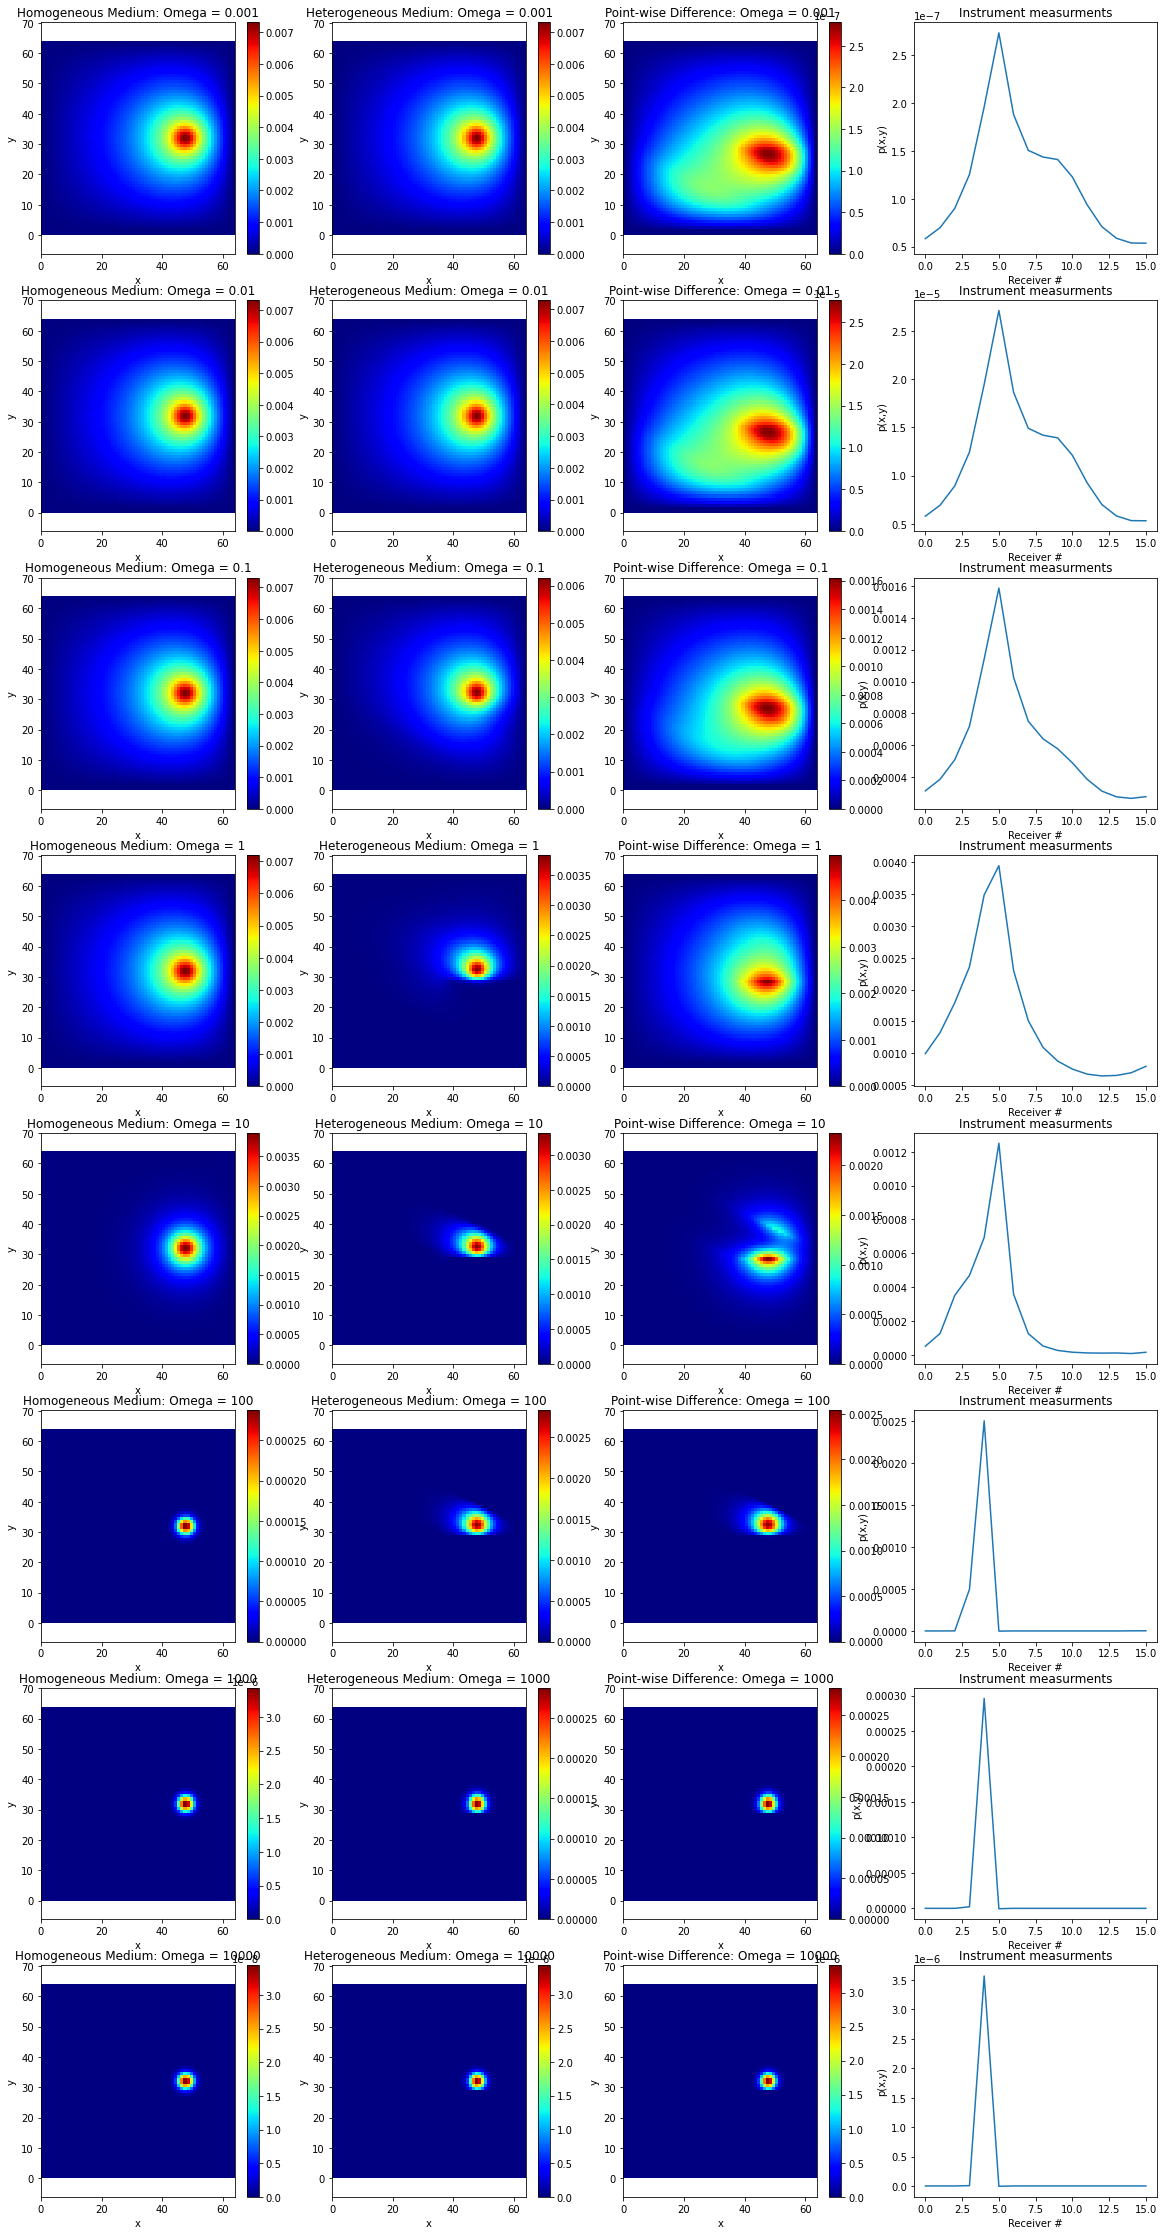

--- 0.2059345245361328 seconds ---
--- 0.22593331336975098 seconds ---
--- 0.2289285659790039 seconds ---
--- 0.24791479110717773 seconds ---
--- 0.20394468307495117 seconds ---
--- 0.20393610000610352 seconds ---
--- 0.2029285430908203 seconds ---
--- 0.22593927383422852 seconds ---
--- 0.19796466827392578 seconds ---
--- 0.20993614196777344 seconds ---
--- 0.1949150562286377 seconds ---
--- 0.1969616413116455 seconds ---
--- 0.2019519805908203 seconds ---
--- 0.22392821311950684 seconds ---
--- 0.22592902183532715 seconds ---
--- 0.23396539688110352 seconds ---
### 4.584662199020386 seconds ###


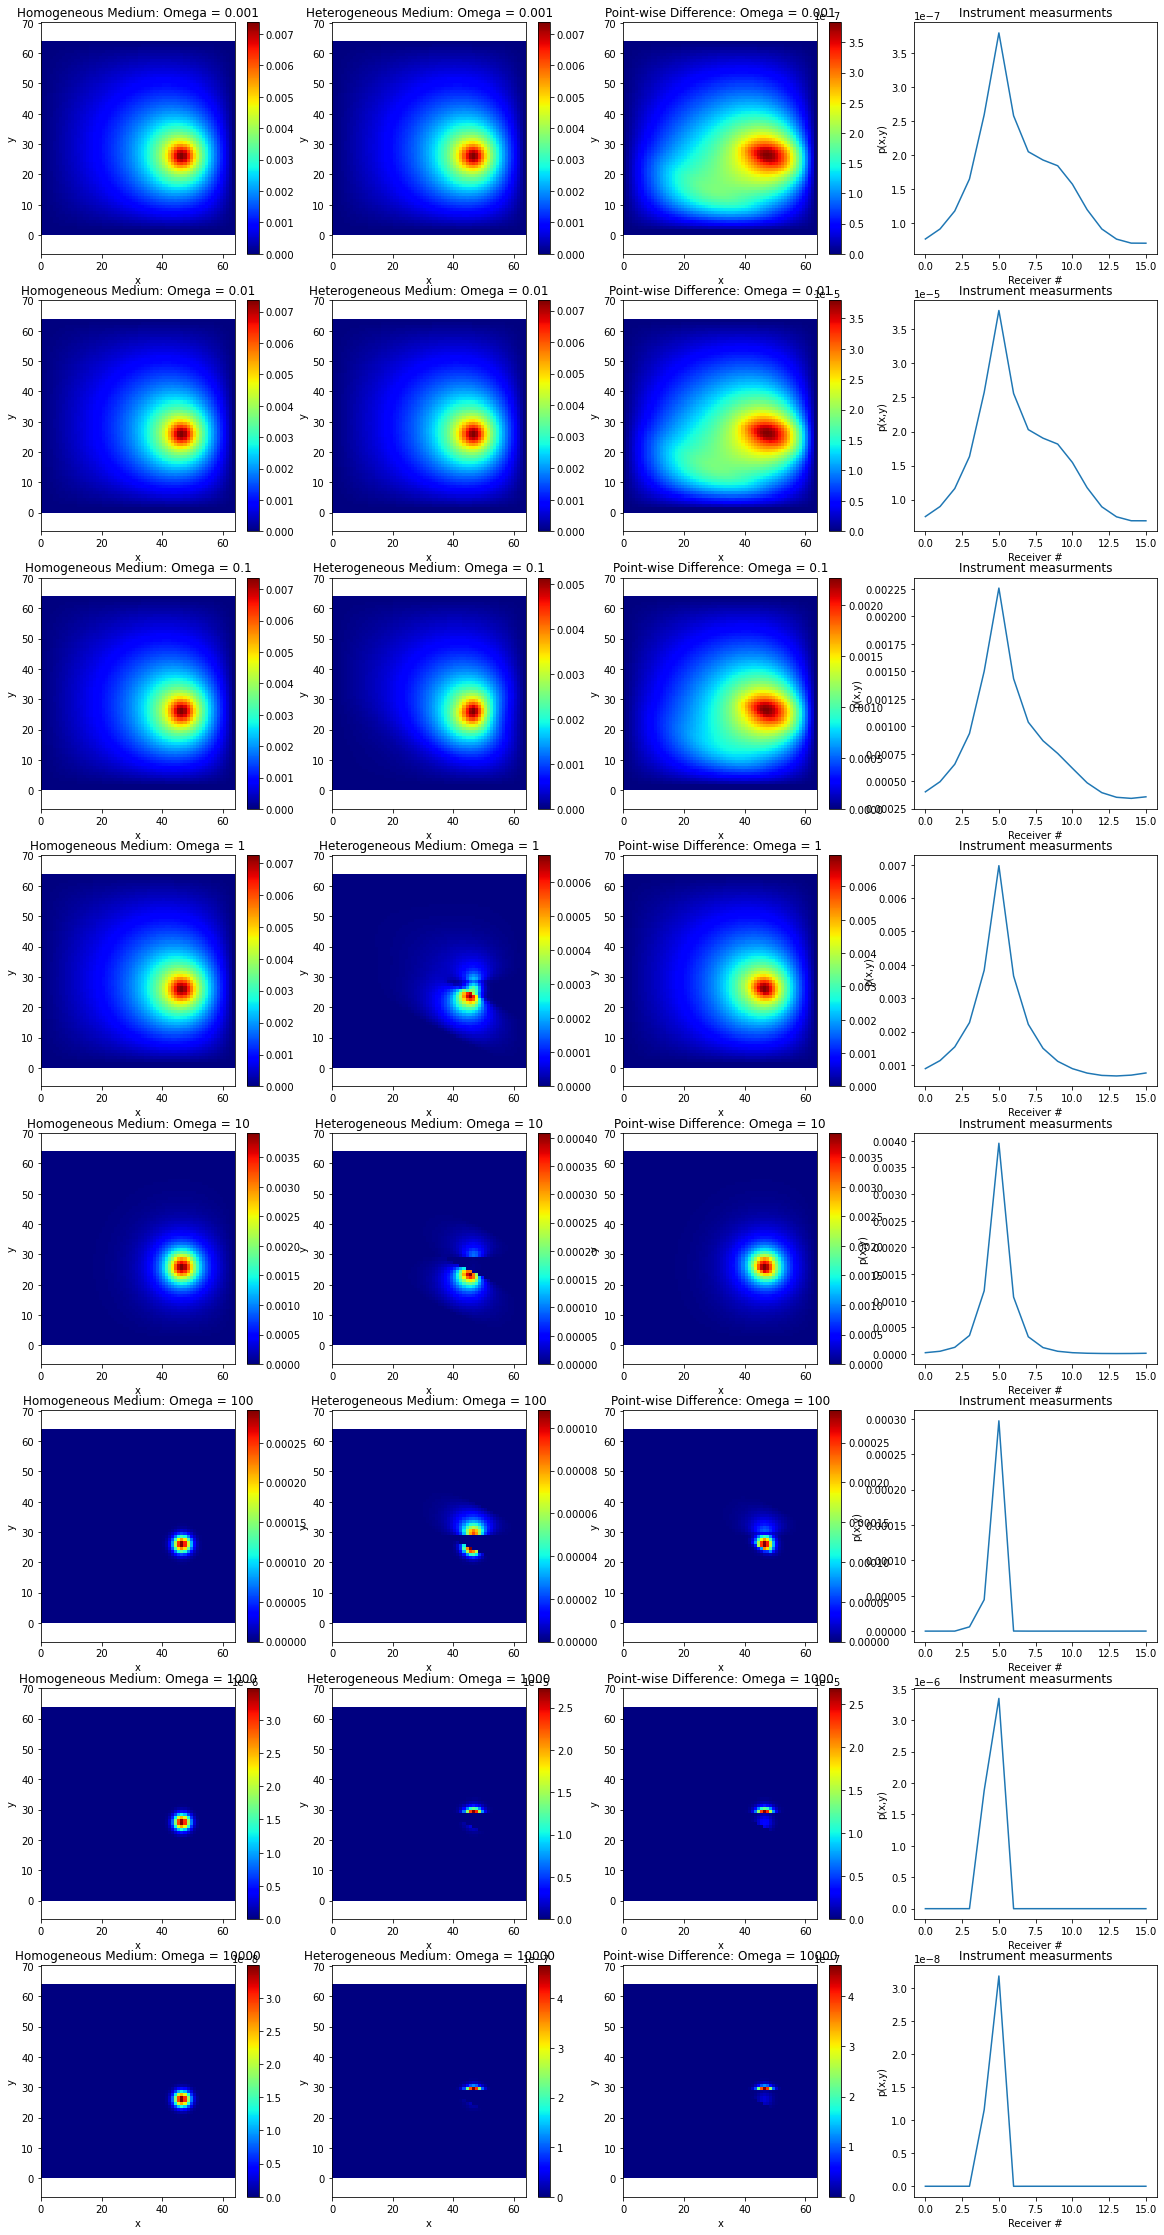

--- 0.22695660591125488 seconds ---
--- 0.2169334888458252 seconds ---
--- 0.20393657684326172 seconds ---
--- 0.2040870189666748 seconds ---
--- 0.21298694610595703 seconds ---
--- 0.20209026336669922 seconds ---
--- 0.20293807983398438 seconds ---
--- 0.21709012985229492 seconds ---
--- 0.19097042083740234 seconds ---
--- 0.22722101211547852 seconds ---
--- 0.19294190406799316 seconds ---
--- 0.22709989547729492 seconds ---
--- 0.1899409294128418 seconds ---
--- 0.19094109535217285 seconds ---
--- 0.2049403190612793 seconds ---
--- 0.2009260654449463 seconds ---
### 4.477095365524292 seconds ###


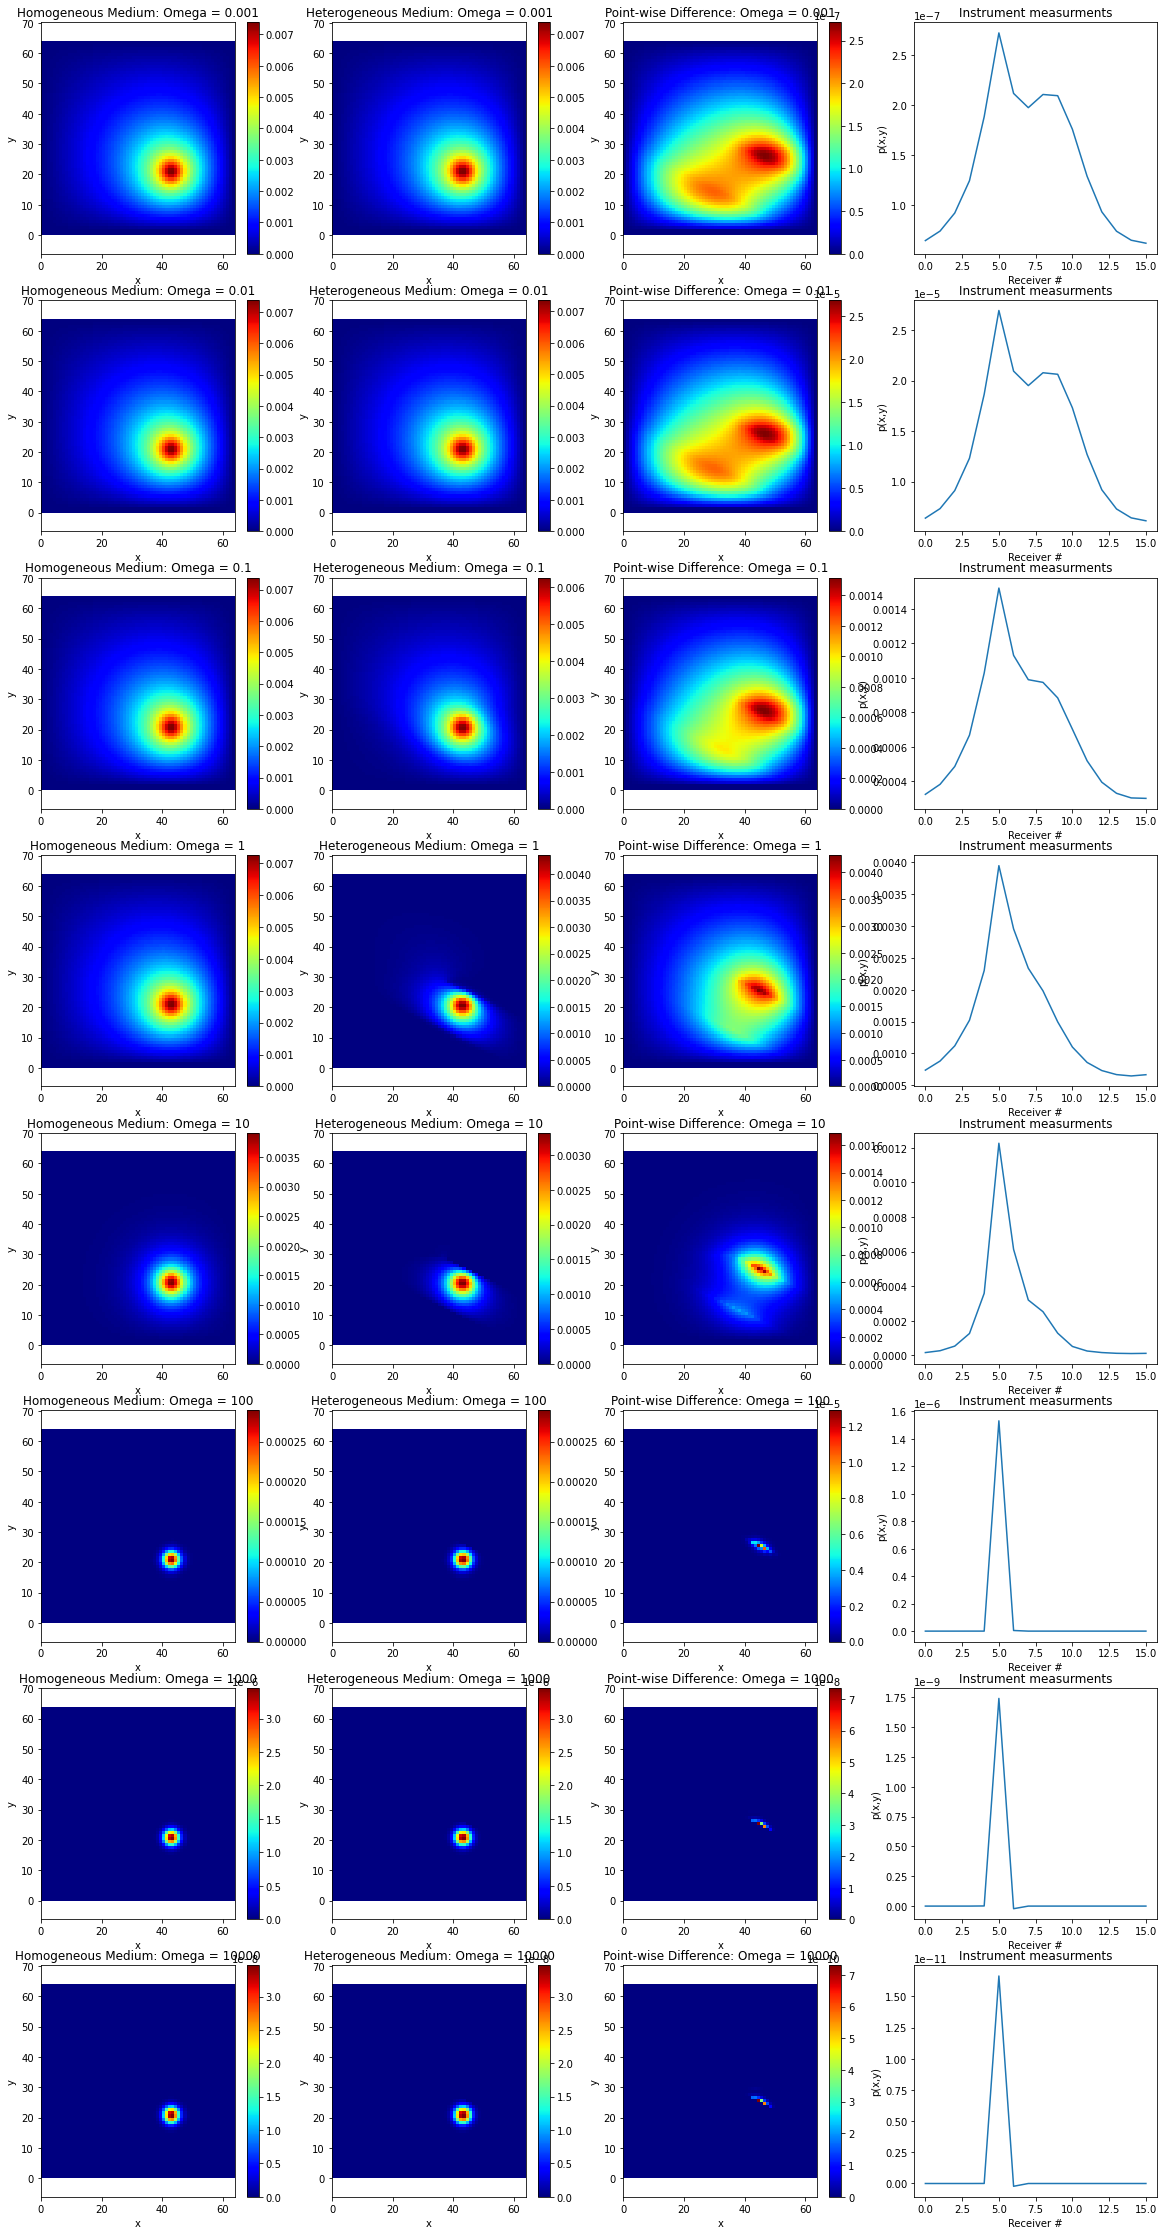

--- 0.2249598503112793 seconds ---
--- 0.23892569541931152 seconds ---
--- 0.1919412612915039 seconds ---
--- 0.2329270839691162 seconds ---
--- 0.20093655586242676 seconds ---
--- 0.1919410228729248 seconds ---
--- 0.19614028930664062 seconds ---
--- 0.20196533203125 seconds ---
--- 0.20325064659118652 seconds ---
--- 0.20993447303771973 seconds ---
--- 0.21799135208129883 seconds ---
--- 0.20911002159118652 seconds ---
--- 0.20990777015686035 seconds ---
--- 0.21196413040161133 seconds ---
--- 0.20307445526123047 seconds ---
--- 0.19993925094604492 seconds ---
### 4.548702001571655 seconds ###


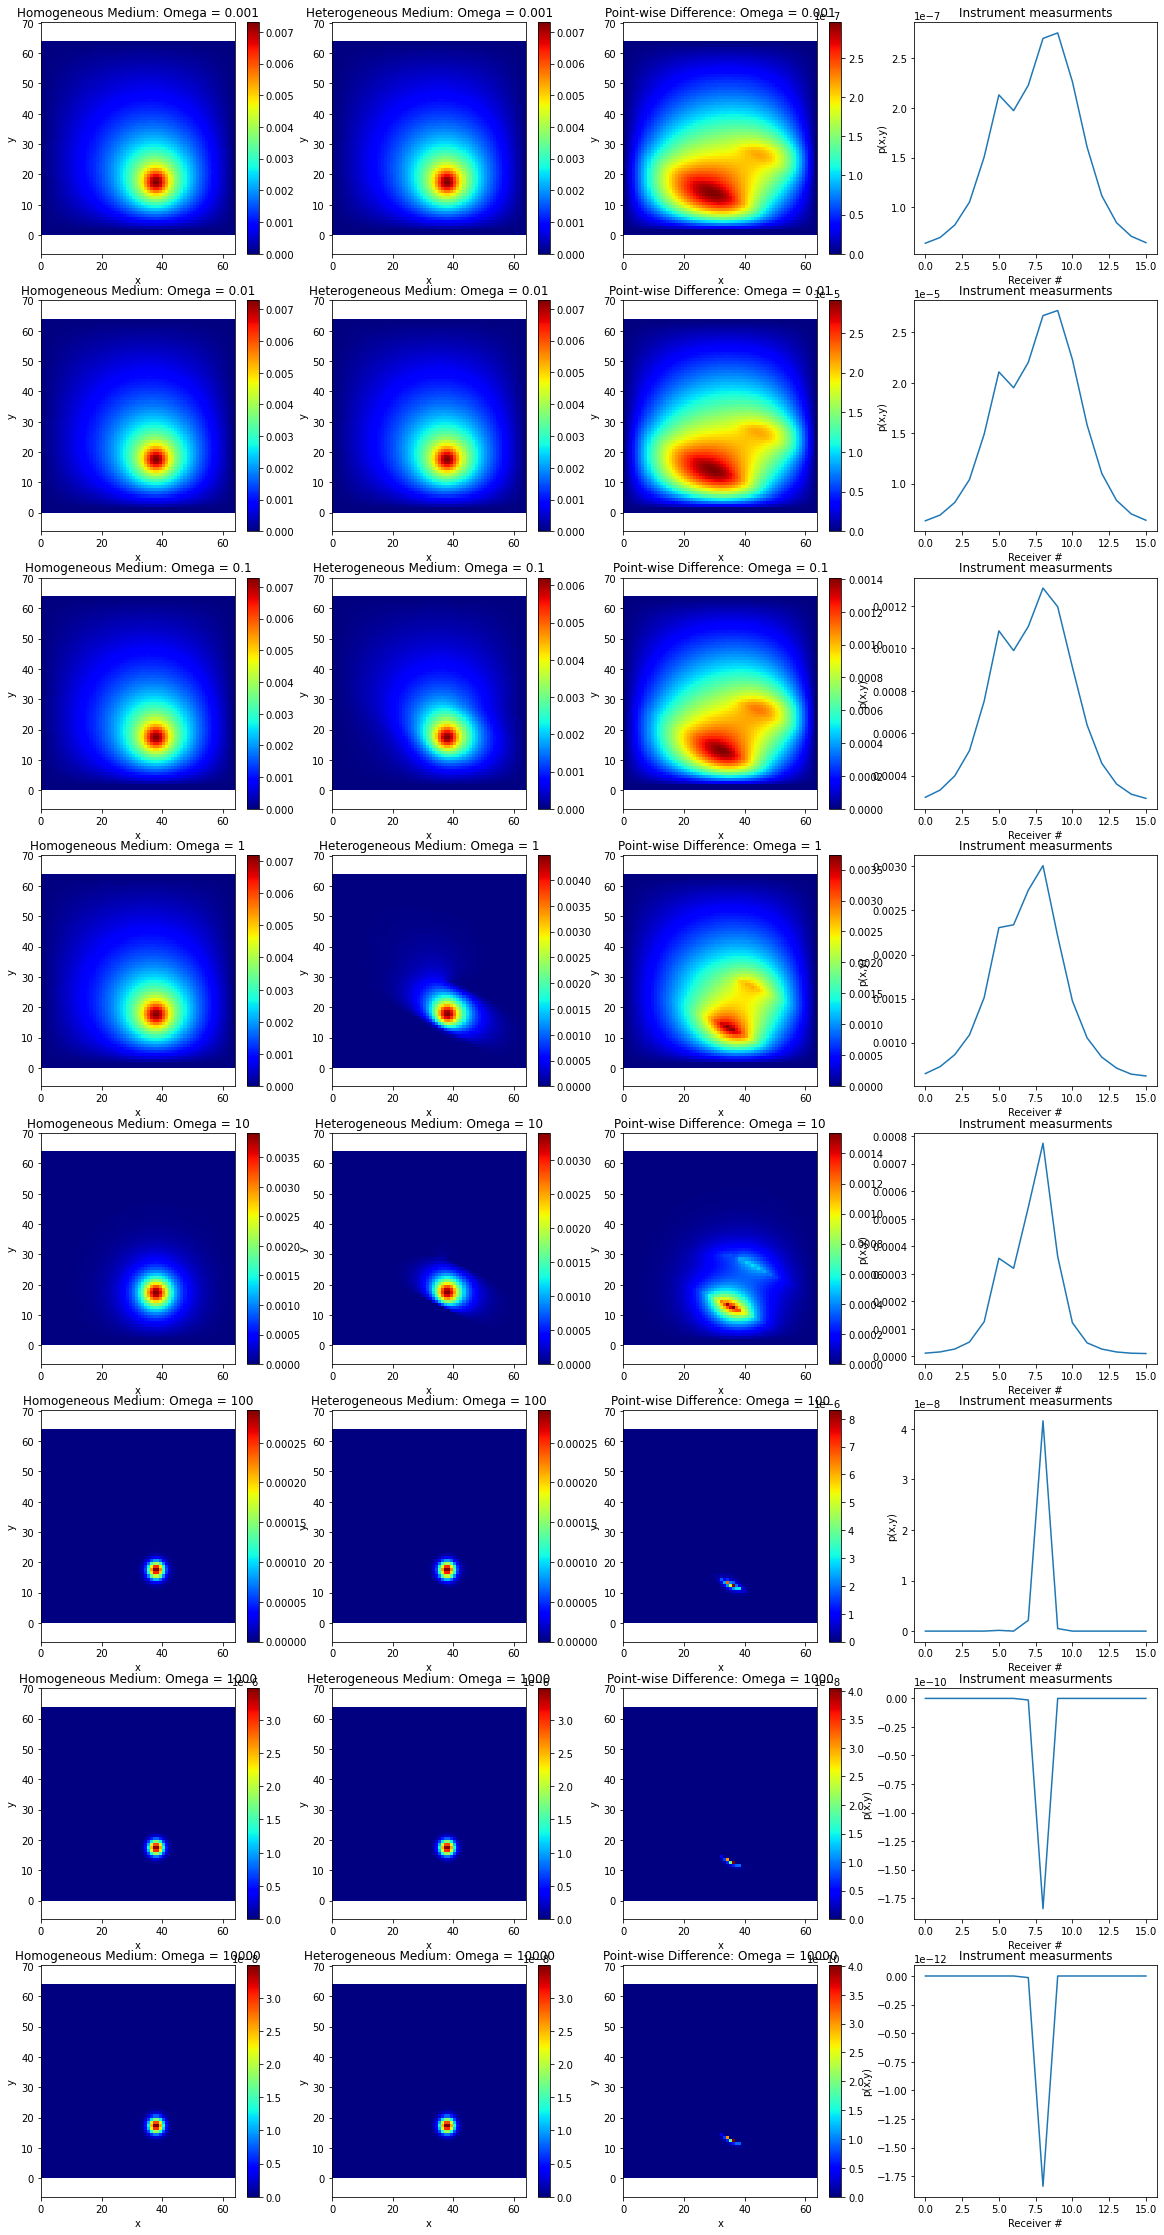

--- 0.20396828651428223 seconds ---
--- 0.20491671562194824 seconds ---
--- 0.20293712615966797 seconds ---
--- 0.22504568099975586 seconds ---
--- 0.19491338729858398 seconds ---
--- 0.24209022521972656 seconds ---
--- 0.20208454132080078 seconds ---
--- 0.2029879093170166 seconds ---
--- 0.201096773147583 seconds ---
--- 0.23792529106140137 seconds ---
--- 0.20193696022033691 seconds ---
--- 0.23789596557617188 seconds ---
--- 0.2019362449645996 seconds ---
--- 0.25092387199401855 seconds ---
--- 0.22992873191833496 seconds ---
--- 0.21693158149719238 seconds ---
### 4.766322135925293 seconds ###


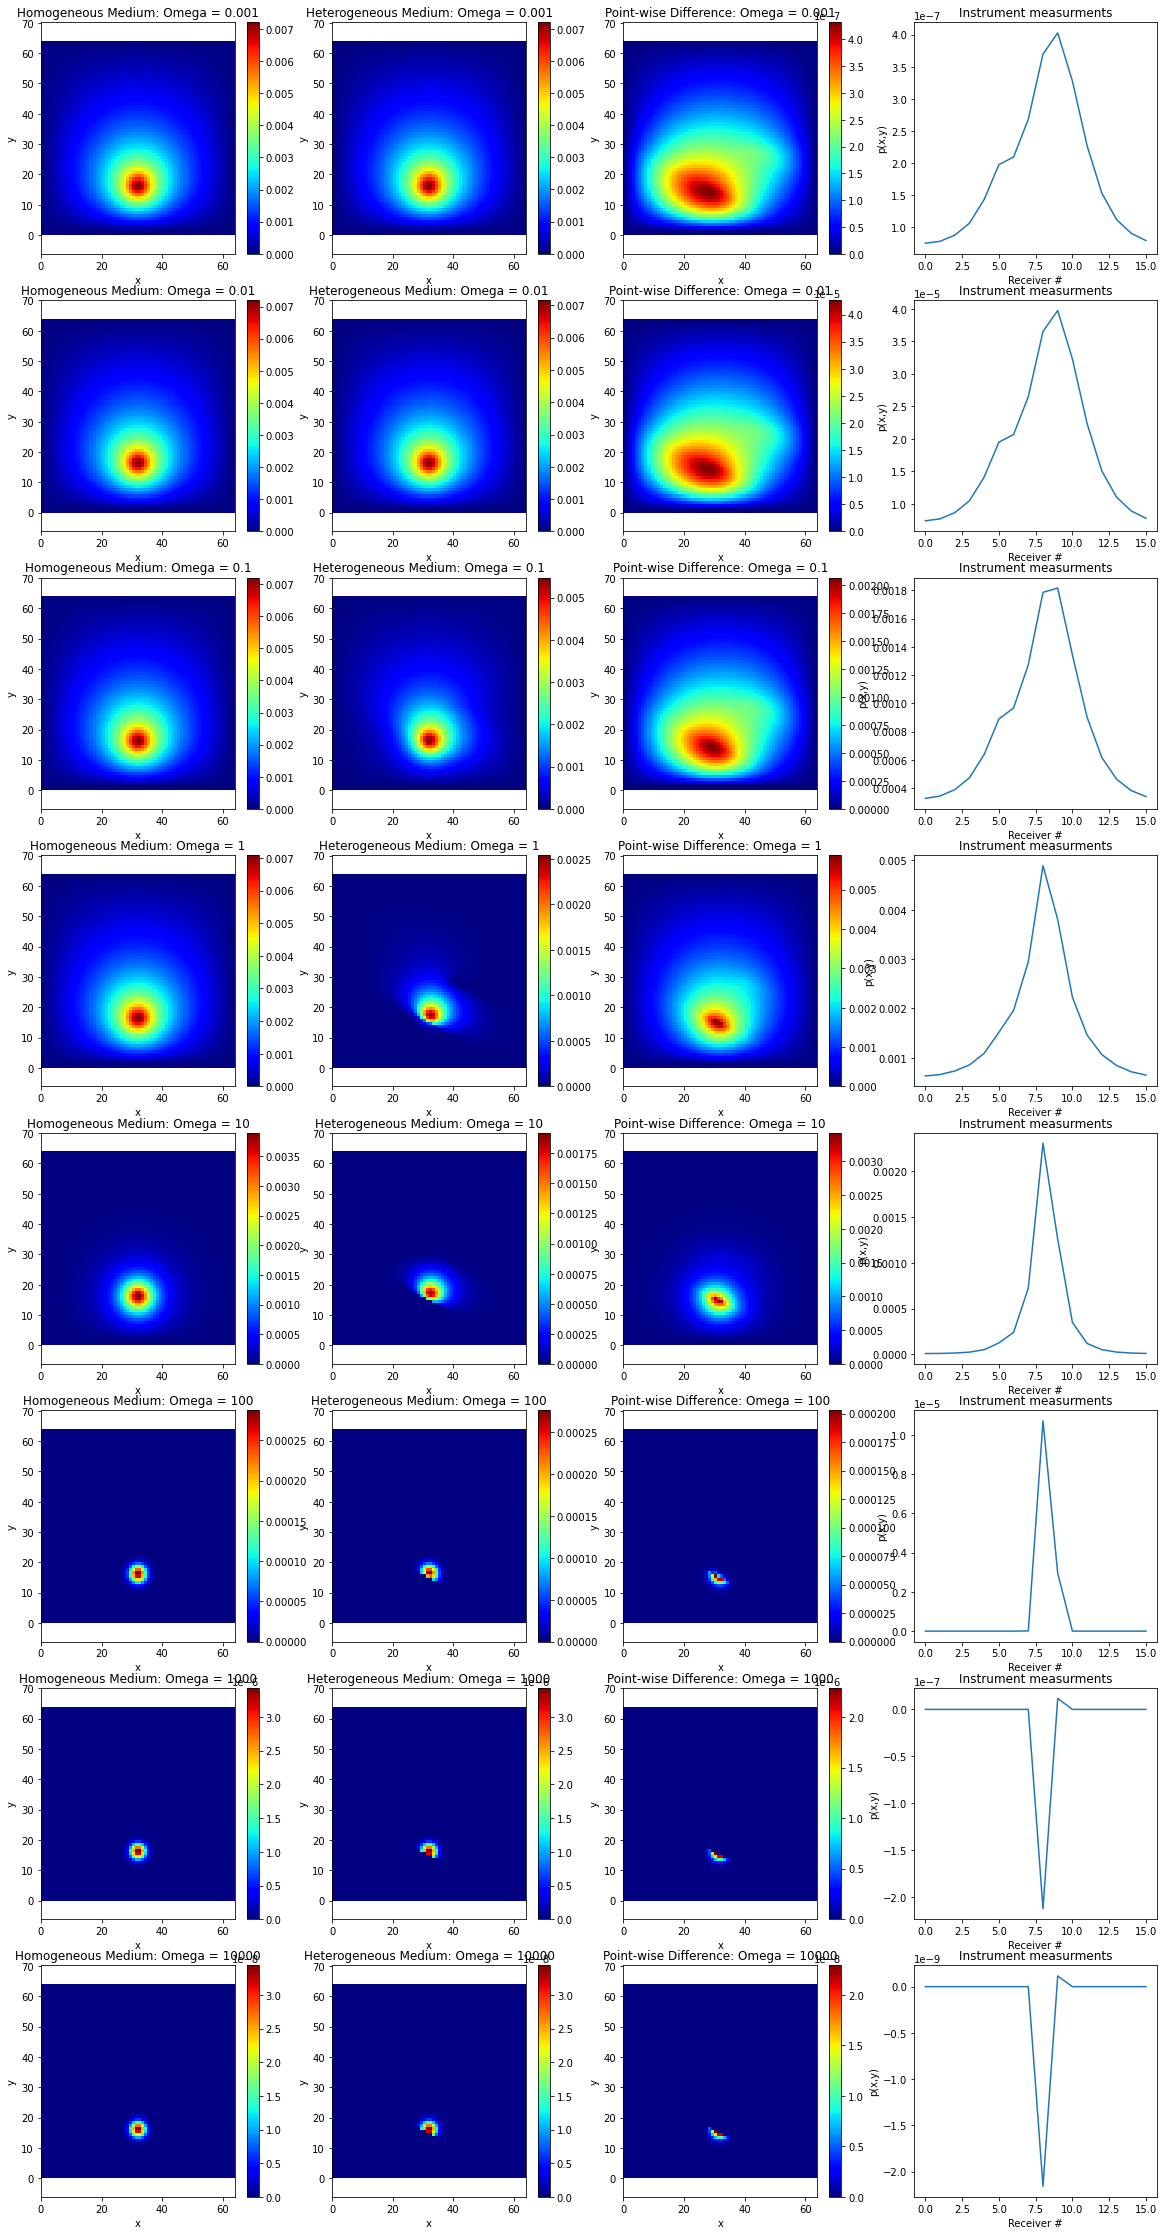

--- 0.20493483543395996 seconds ---
--- 0.2019362449645996 seconds ---
--- 0.20293712615966797 seconds ---
--- 0.21093487739562988 seconds ---
--- 0.2169332504272461 seconds ---
--- 0.24792170524597168 seconds ---
--- 0.20496630668640137 seconds ---
--- 0.22889995574951172 seconds ---
--- 0.20393872261047363 seconds ---
--- 0.22089910507202148 seconds ---
--- 0.19794321060180664 seconds ---
--- 0.1959395408630371 seconds ---
--- 0.1919403076171875 seconds ---
--- 0.2249307632446289 seconds ---
--- 0.20593595504760742 seconds ---
--- 0.20691394805908203 seconds ---
### 4.566918134689331 seconds ###


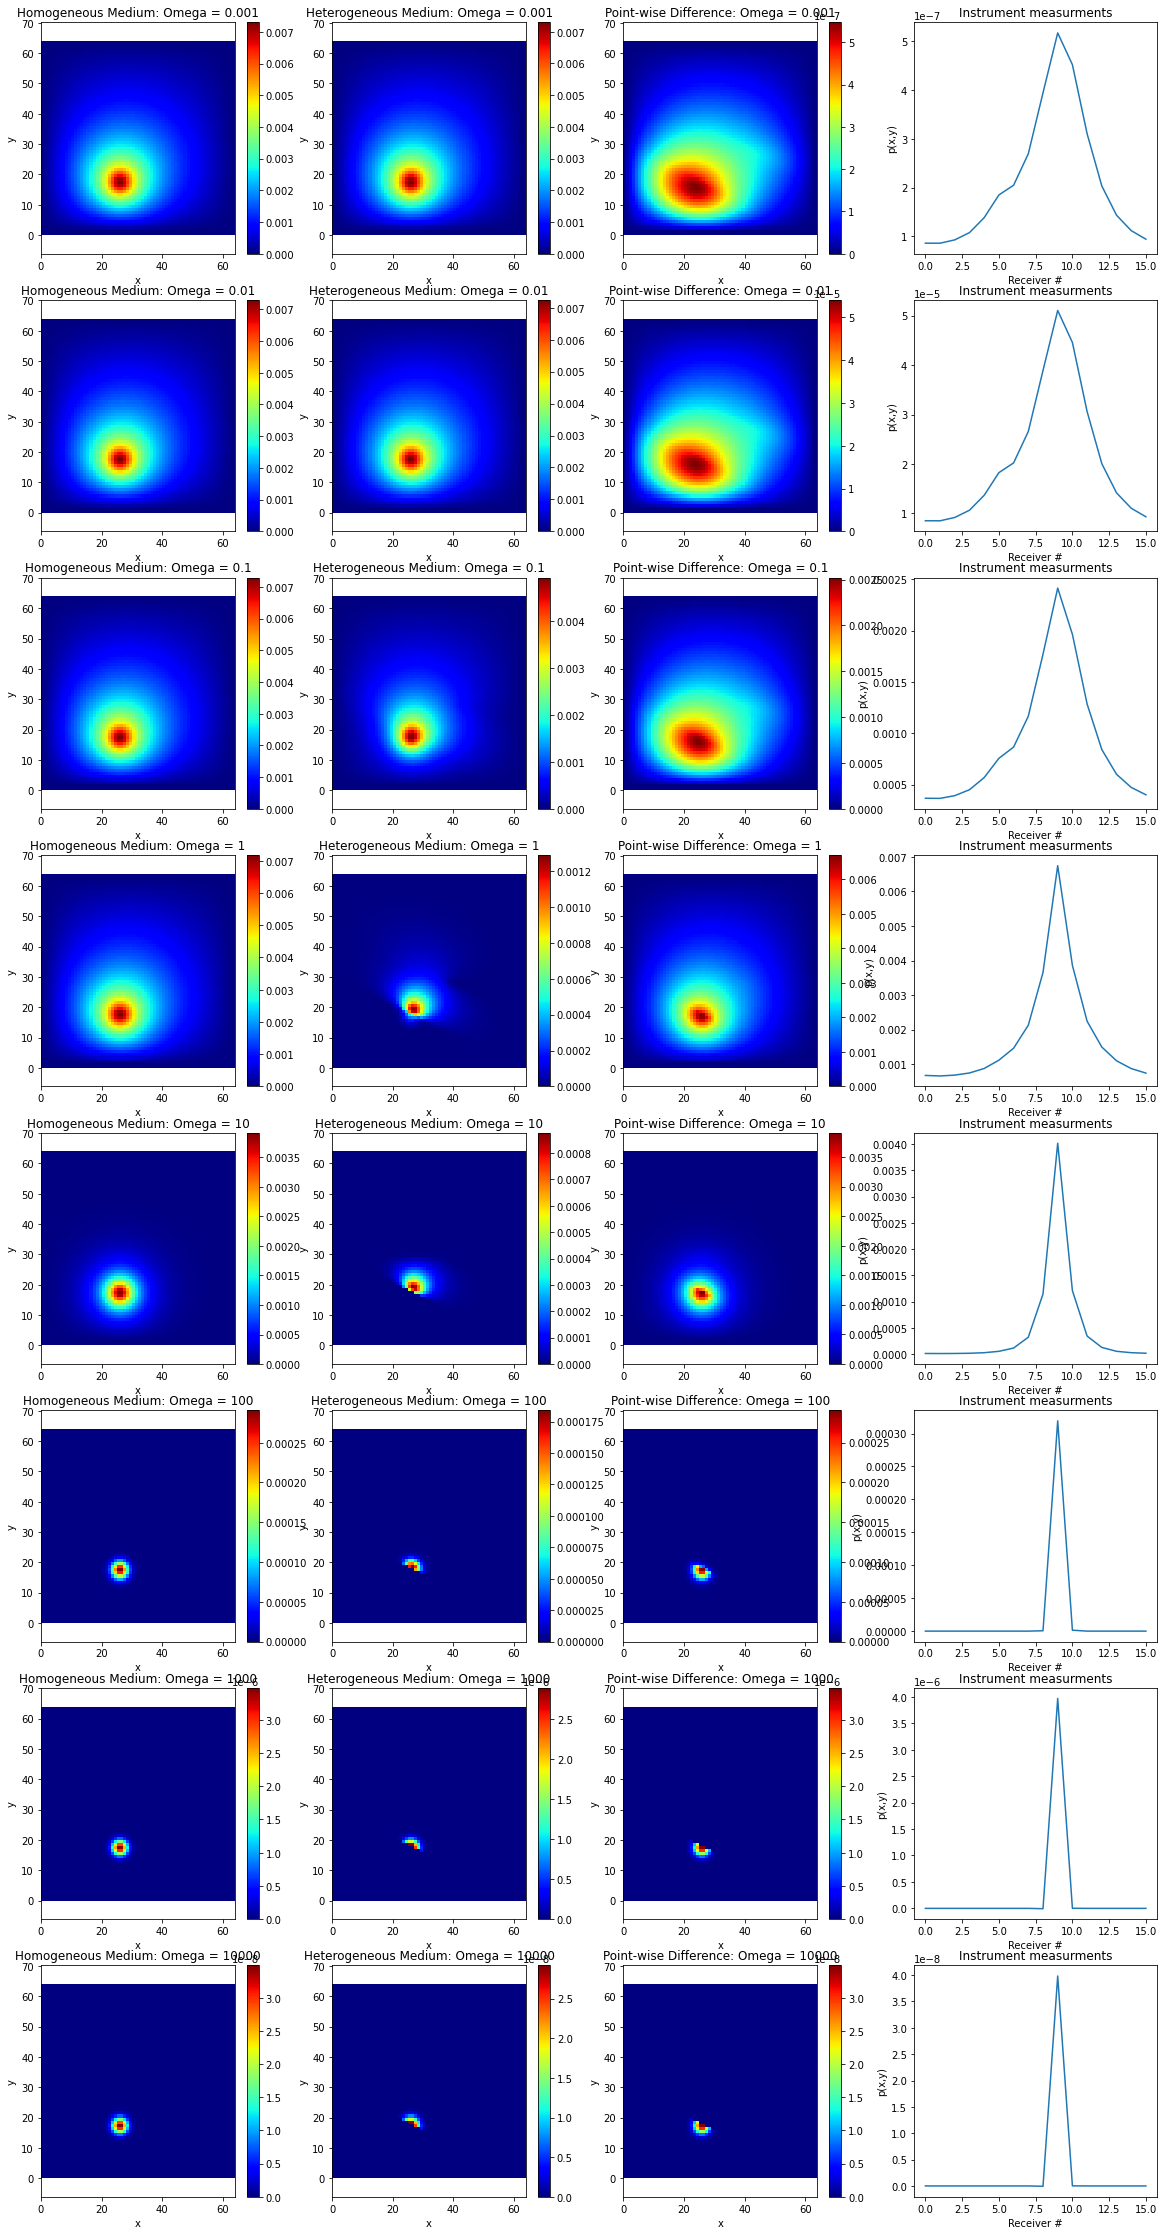

--- 0.23992657661437988 seconds ---
--- 0.25489258766174316 seconds ---
--- 0.19094014167785645 seconds ---
--- 0.21624326705932617 seconds ---
--- 0.208085298538208 seconds ---
--- 0.220930814743042 seconds ---
--- 0.20408916473388672 seconds ---
--- 0.21393346786499023 seconds ---
--- 0.20112895965576172 seconds ---
--- 0.2549557685852051 seconds ---
--- 0.21307873725891113 seconds ---
--- 0.2599949836730957 seconds ---
--- 0.20393657684326172 seconds ---
--- 0.20393753051757812 seconds ---
--- 0.20902132987976074 seconds ---
--- 0.2321619987487793 seconds ---
### 4.737144470214844 seconds ###


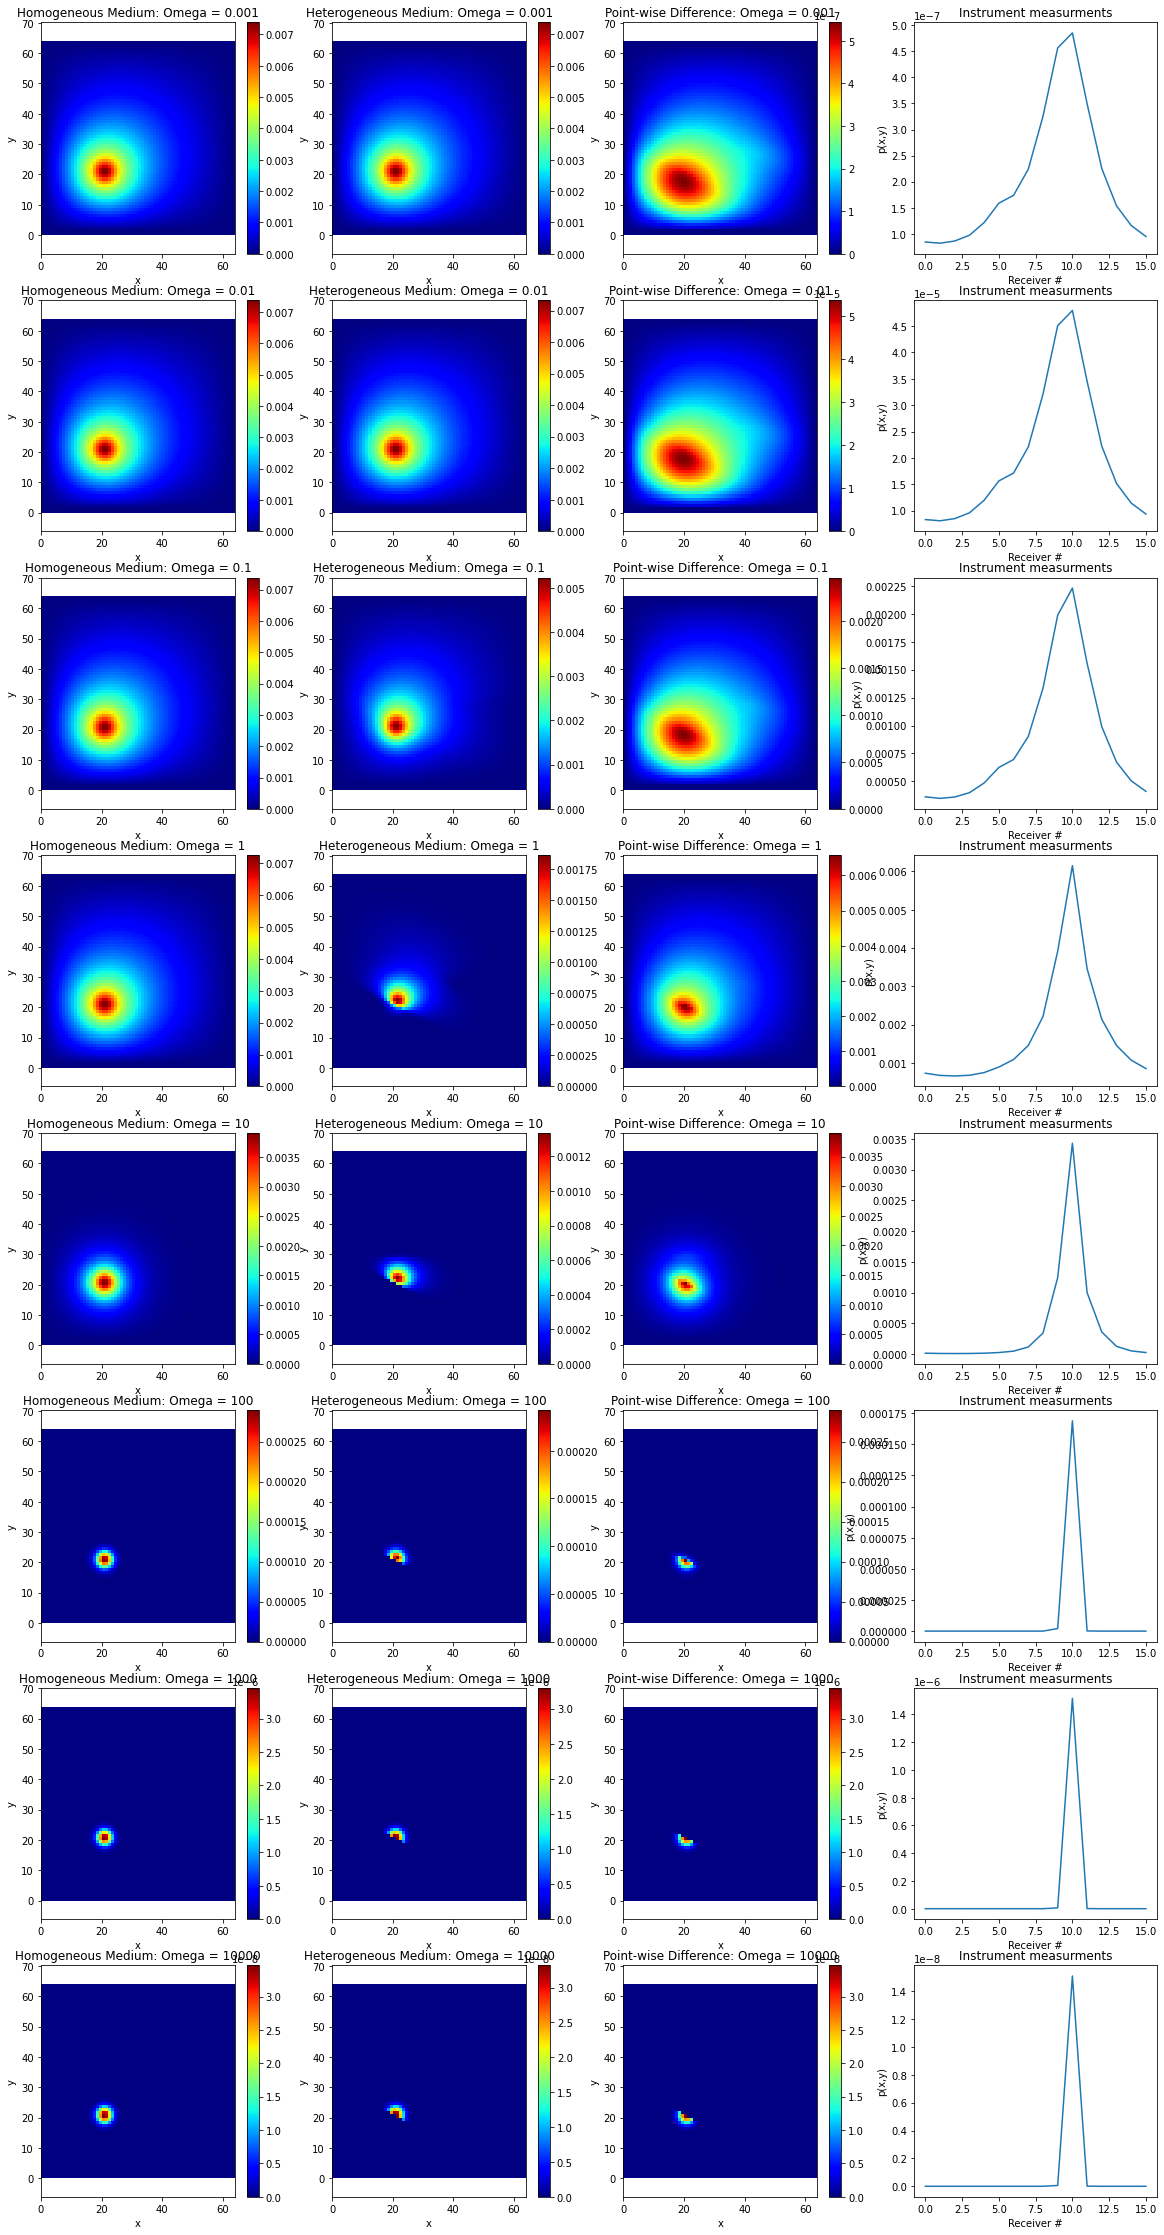

--- 0.22292804718017578 seconds ---
--- 0.21095561981201172 seconds ---
--- 0.1951160430908203 seconds ---
--- 0.20594191551208496 seconds ---
--- 0.20293617248535156 seconds ---
--- 0.20125150680541992 seconds ---
--- 0.22890377044677734 seconds ---
--- 0.21500158309936523 seconds ---
--- 0.20002436637878418 seconds ---
--- 0.20894289016723633 seconds ---
--- 0.2219374179840088 seconds ---
--- 0.22501540184020996 seconds ---
--- 0.2020397186279297 seconds ---
--- 0.2169783115386963 seconds ---
--- 0.20597457885742188 seconds ---
--- 0.2799818515777588 seconds ---
### 4.588897705078125 seconds ###


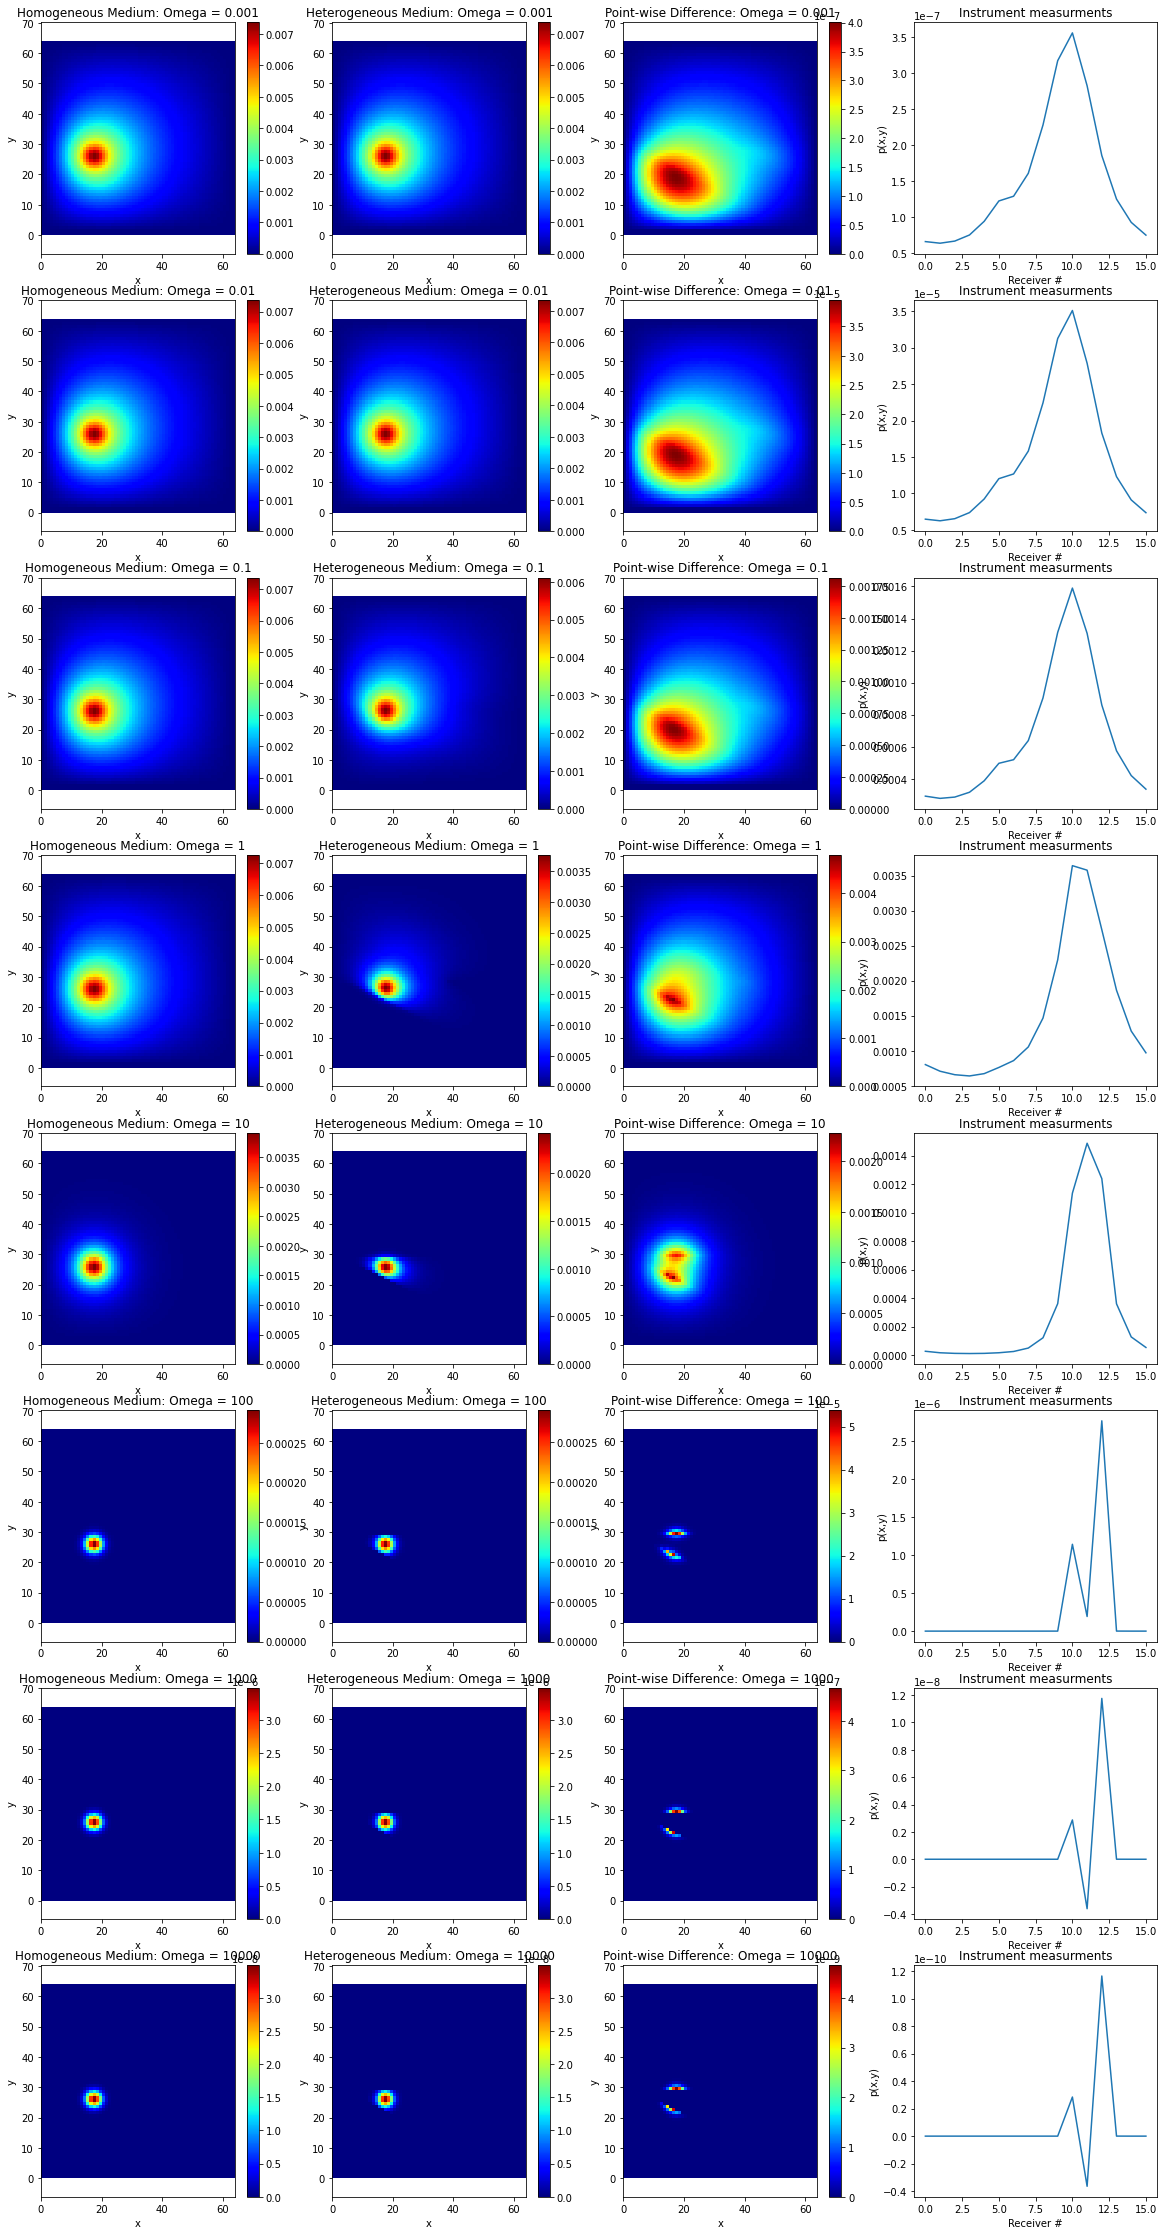

--- 0.21494174003601074 seconds ---
--- 0.2358994483947754 seconds ---
--- 0.22999882698059082 seconds ---
--- 0.22601103782653809 seconds ---
--- 0.20593500137329102 seconds ---
--- 0.21223068237304688 seconds ---
--- 0.20303916931152344 seconds ---
--- 0.20592713356018066 seconds ---
--- 0.2019360065460205 seconds ---
--- 0.2039933204650879 seconds ---
--- 0.19401049613952637 seconds ---
--- 0.21603155136108398 seconds ---
--- 0.19599103927612305 seconds ---
--- 0.21896862983703613 seconds ---
--- 0.21238446235656738 seconds ---
--- 0.20093750953674316 seconds ---
### 4.666214466094971 seconds ###


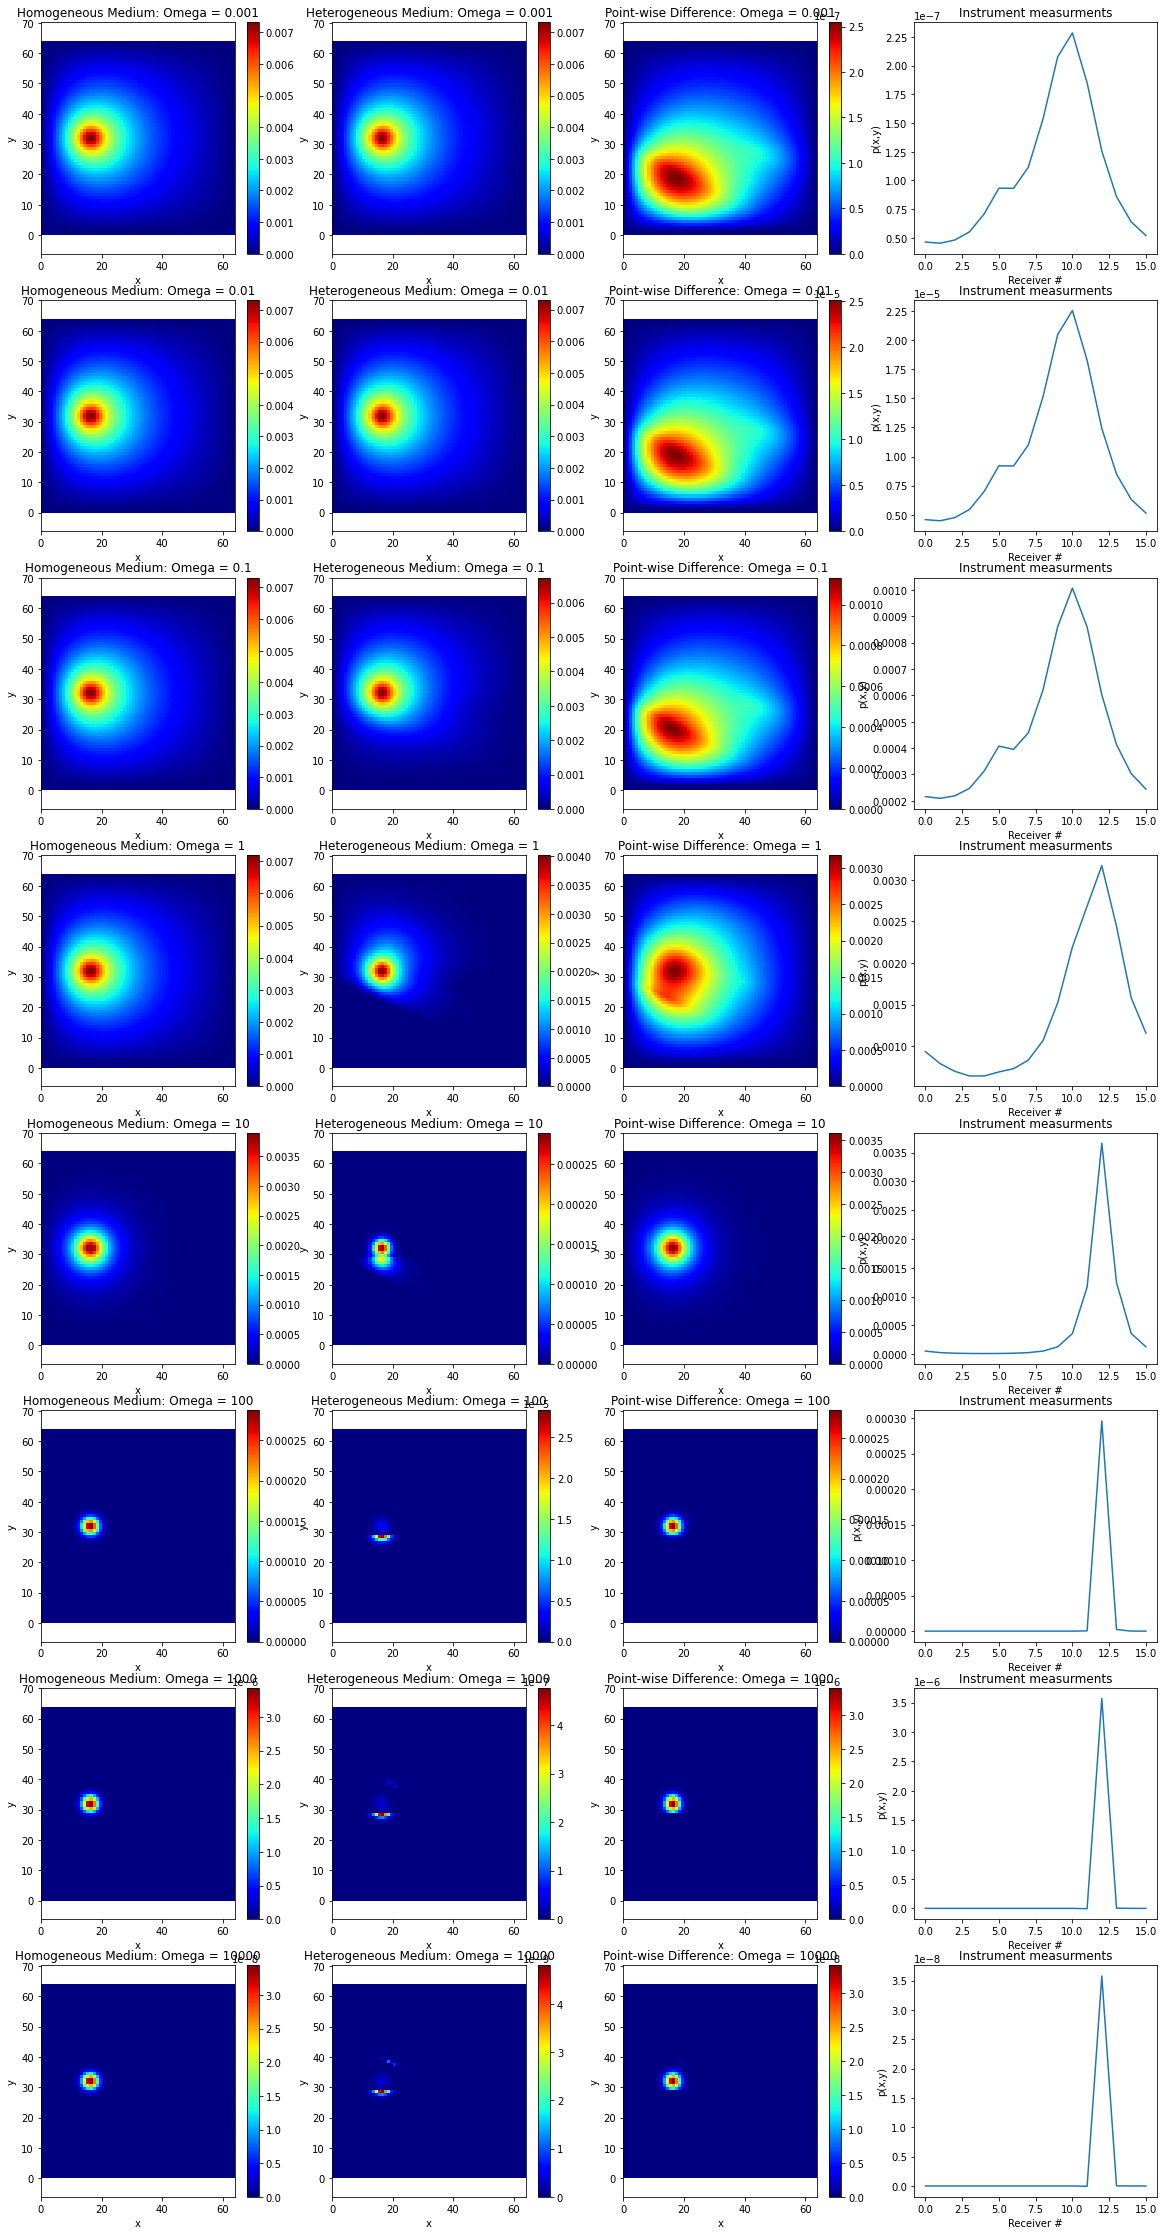

--- 0.21492671966552734 seconds ---
--- 0.22090578079223633 seconds ---
--- 0.20293807983398438 seconds ---
--- 0.21593213081359863 seconds ---
--- 0.19100689888000488 seconds ---
--- 0.20503687858581543 seconds ---
--- 0.21194696426391602 seconds ---
--- 0.21292710304260254 seconds ---
--- 0.19901013374328613 seconds ---
--- 0.2239699363708496 seconds ---
--- 0.20093679428100586 seconds ---
--- 0.23830962181091309 seconds ---
--- 0.20693469047546387 seconds ---
--- 0.21996092796325684 seconds ---
--- 0.21093368530273438 seconds ---
--- 0.24013948440551758 seconds ---
### 4.521798133850098 seconds ###


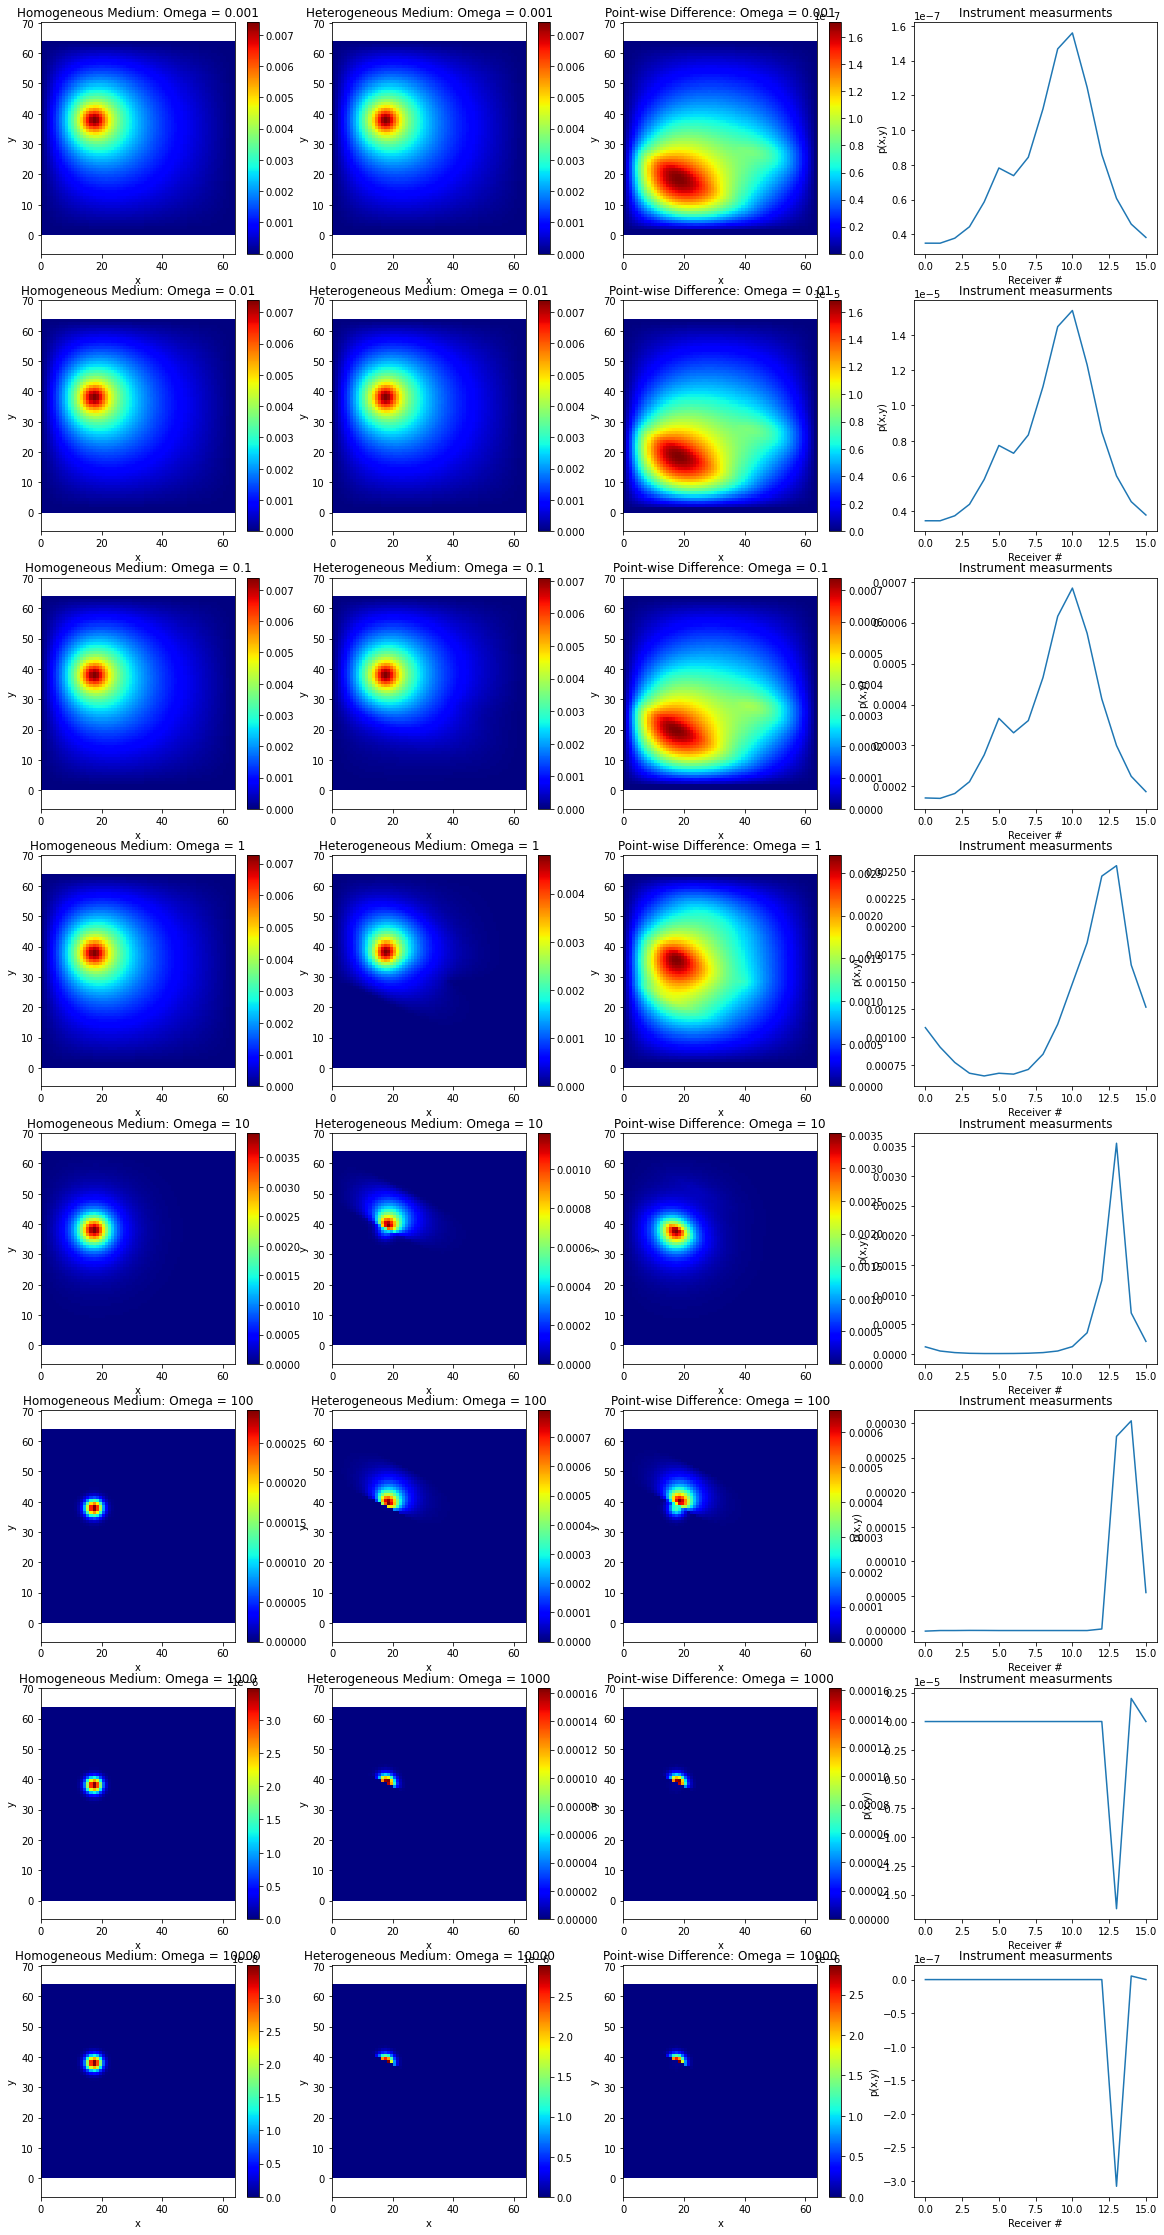

--- 0.21297812461853027 seconds ---
--- 0.27452778816223145 seconds ---
--- 0.20093989372253418 seconds ---
--- 0.22292804718017578 seconds ---
--- 0.20390534400939941 seconds ---
--- 0.20693755149841309 seconds ---
--- 0.19293975830078125 seconds ---
--- 0.19197678565979004 seconds ---
--- 0.19110107421875 seconds ---
--- 0.19093990325927734 seconds ---
--- 0.1911604404449463 seconds ---
--- 0.19201207160949707 seconds ---
--- 0.1999680995941162 seconds ---
--- 0.22700023651123047 seconds ---
--- 0.2069103717803955 seconds ---
--- 0.22507619857788086 seconds ---
### 4.566006183624268 seconds ###


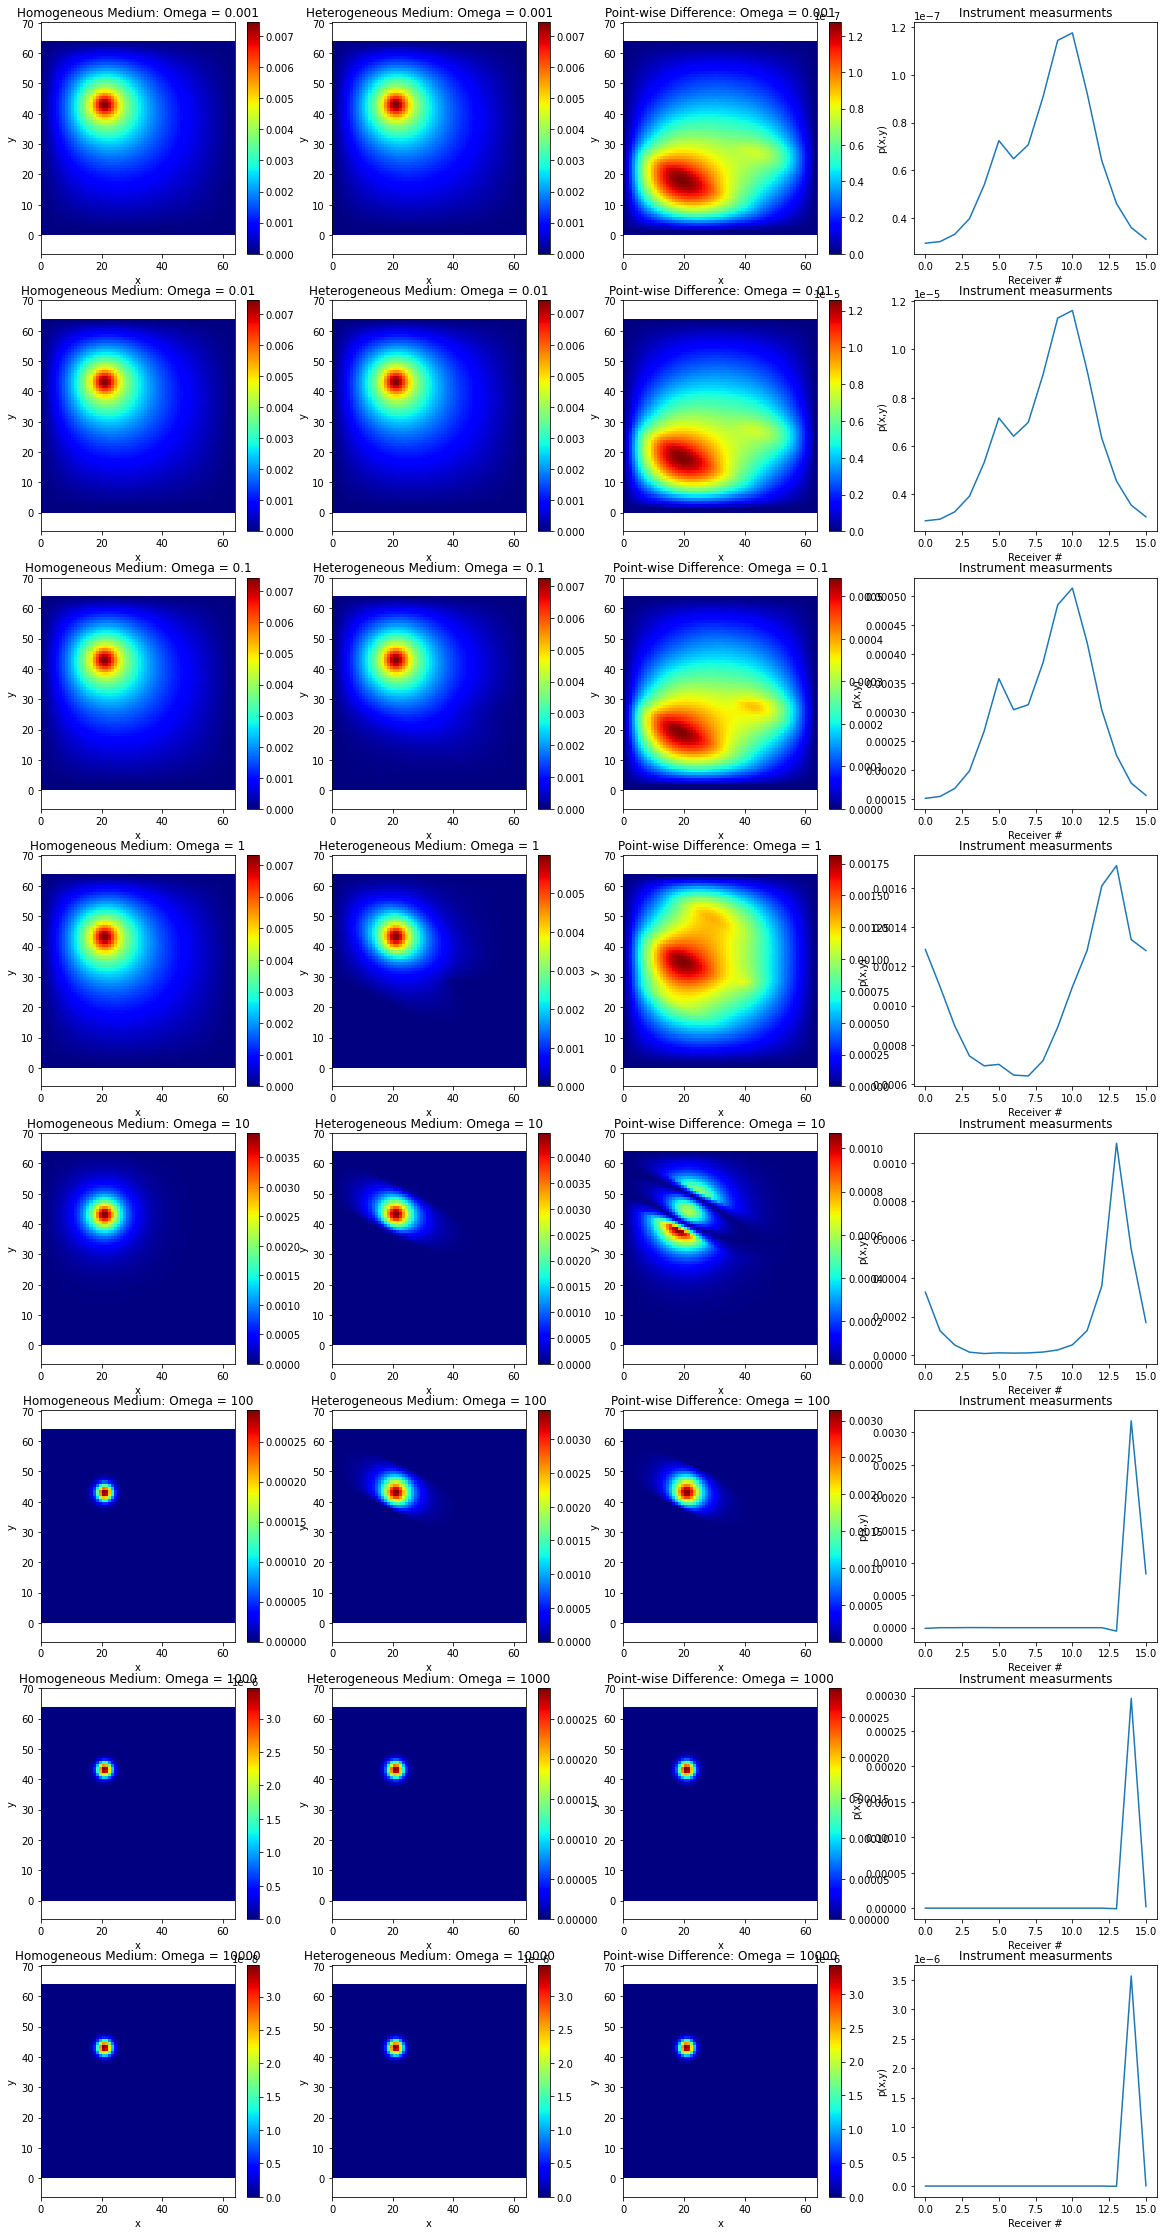

--- 0.21596407890319824 seconds ---
--- 0.2089376449584961 seconds ---
--- 0.1919705867767334 seconds ---
--- 0.19500398635864258 seconds ---
--- 0.2102212905883789 seconds ---
--- 0.24189376831054688 seconds ---
--- 0.19997429847717285 seconds ---
--- 0.20113062858581543 seconds ---
--- 0.20493555068969727 seconds ---
--- 0.202009916305542 seconds ---
--- 0.1979656219482422 seconds ---
--- 0.2089707851409912 seconds ---
--- 0.20500540733337402 seconds ---
--- 0.20319008827209473 seconds ---
--- 0.21094393730163574 seconds ---
--- 0.2230207920074463 seconds ---
### 4.493865489959717 seconds ###


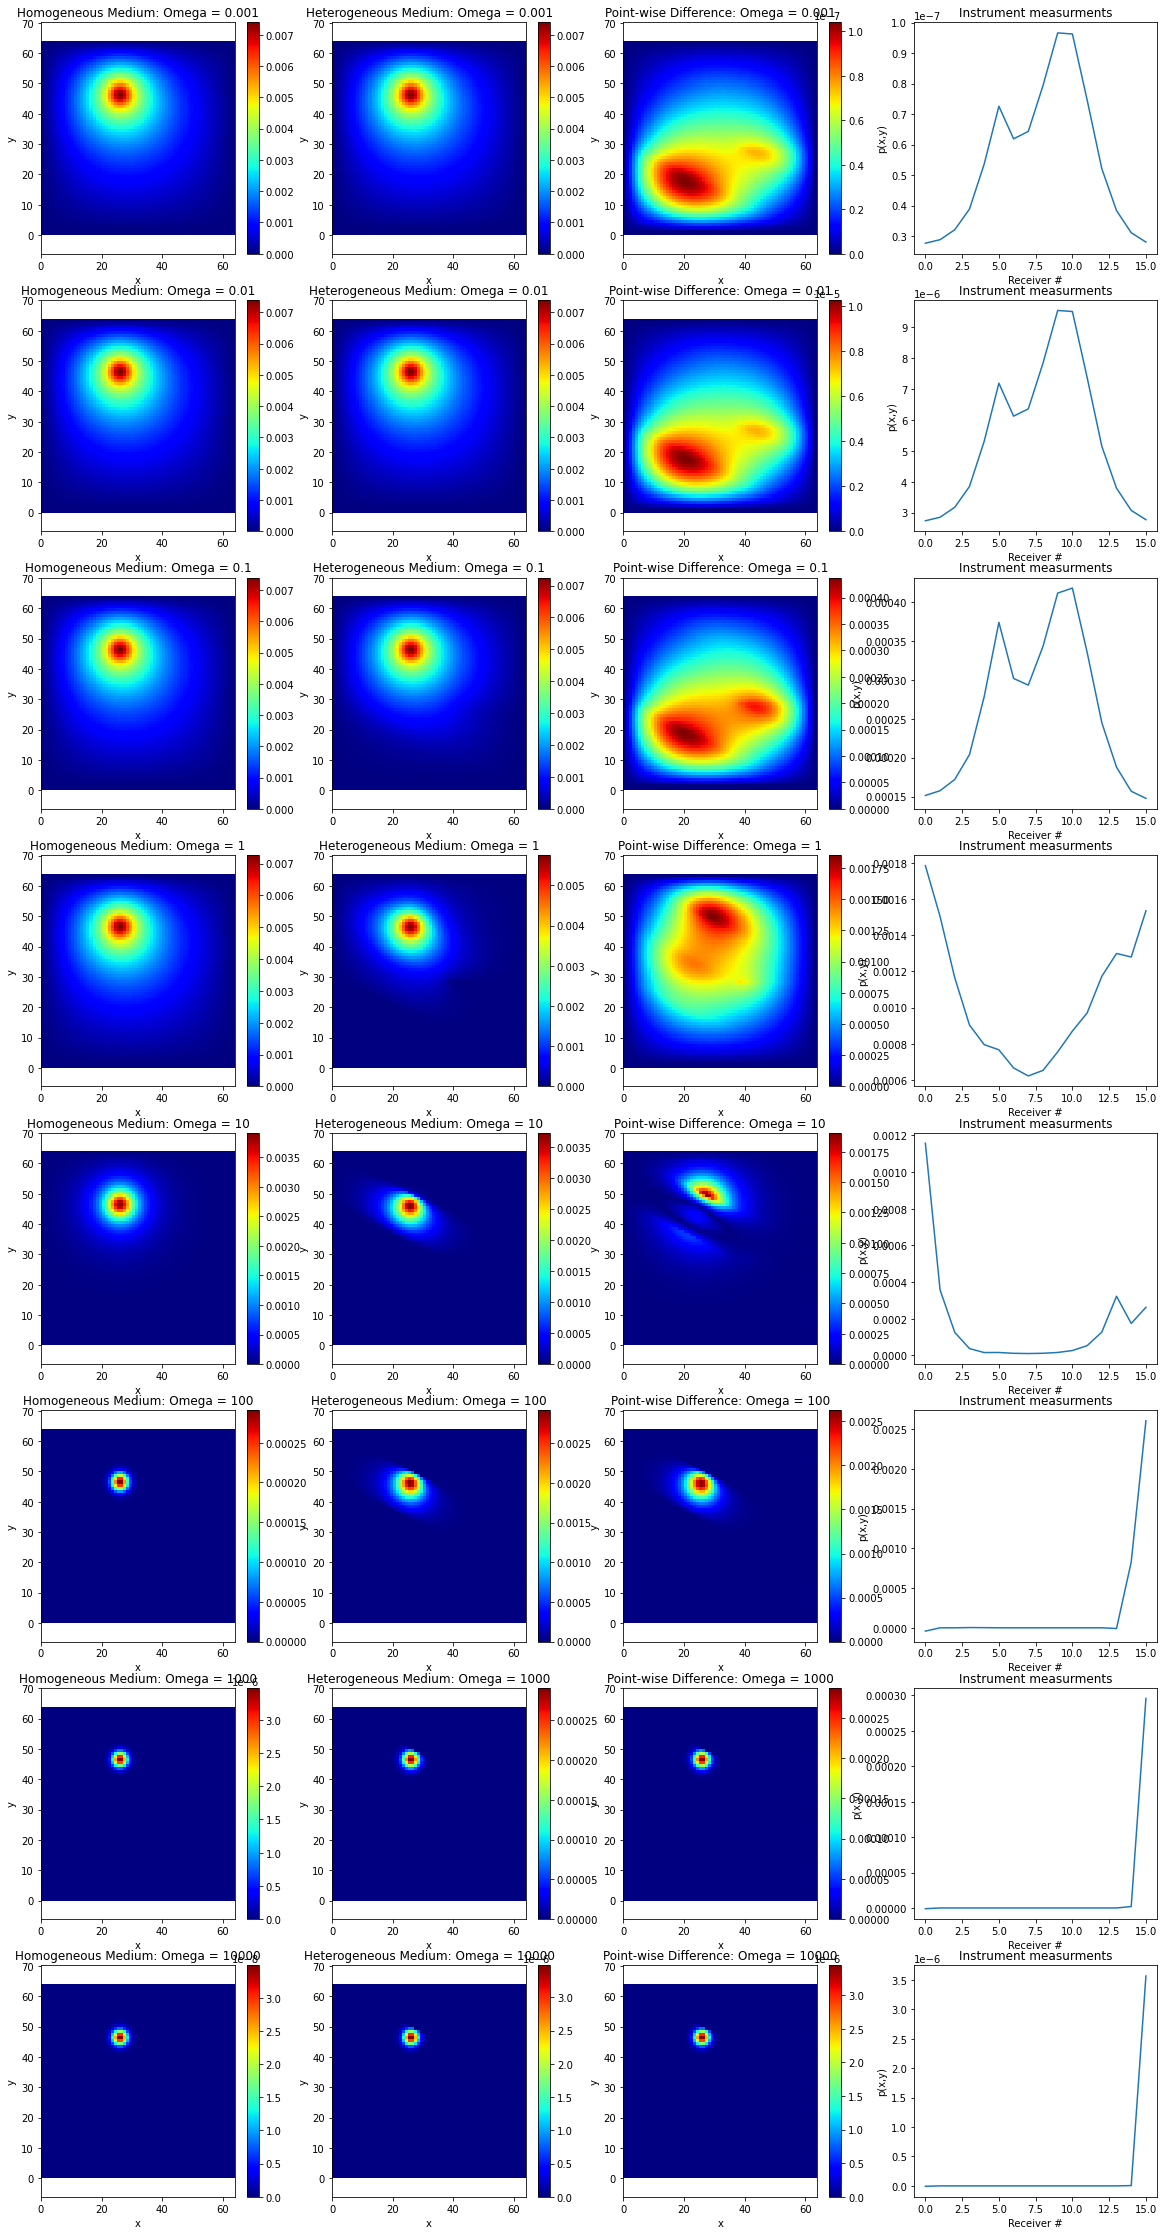

--- 0.21396875381469727 seconds ---
--- 0.20300912857055664 seconds ---
--- 0.20790910720825195 seconds ---
--- 0.21993231773376465 seconds ---
--- 0.20503973960876465 seconds ---
--- 0.20603346824645996 seconds ---
--- 0.2129666805267334 seconds ---
--- 0.29398560523986816 seconds ---
--- 0.20293664932250977 seconds ---
--- 0.20194458961486816 seconds ---
--- 0.23801684379577637 seconds ---
--- 0.22041893005371094 seconds ---
--- 0.20193719863891602 seconds ---
--- 0.22789859771728516 seconds ---
--- 0.19791889190673828 seconds ---
--- 0.19700407981872559 seconds ---
### 4.619012832641602 seconds ###


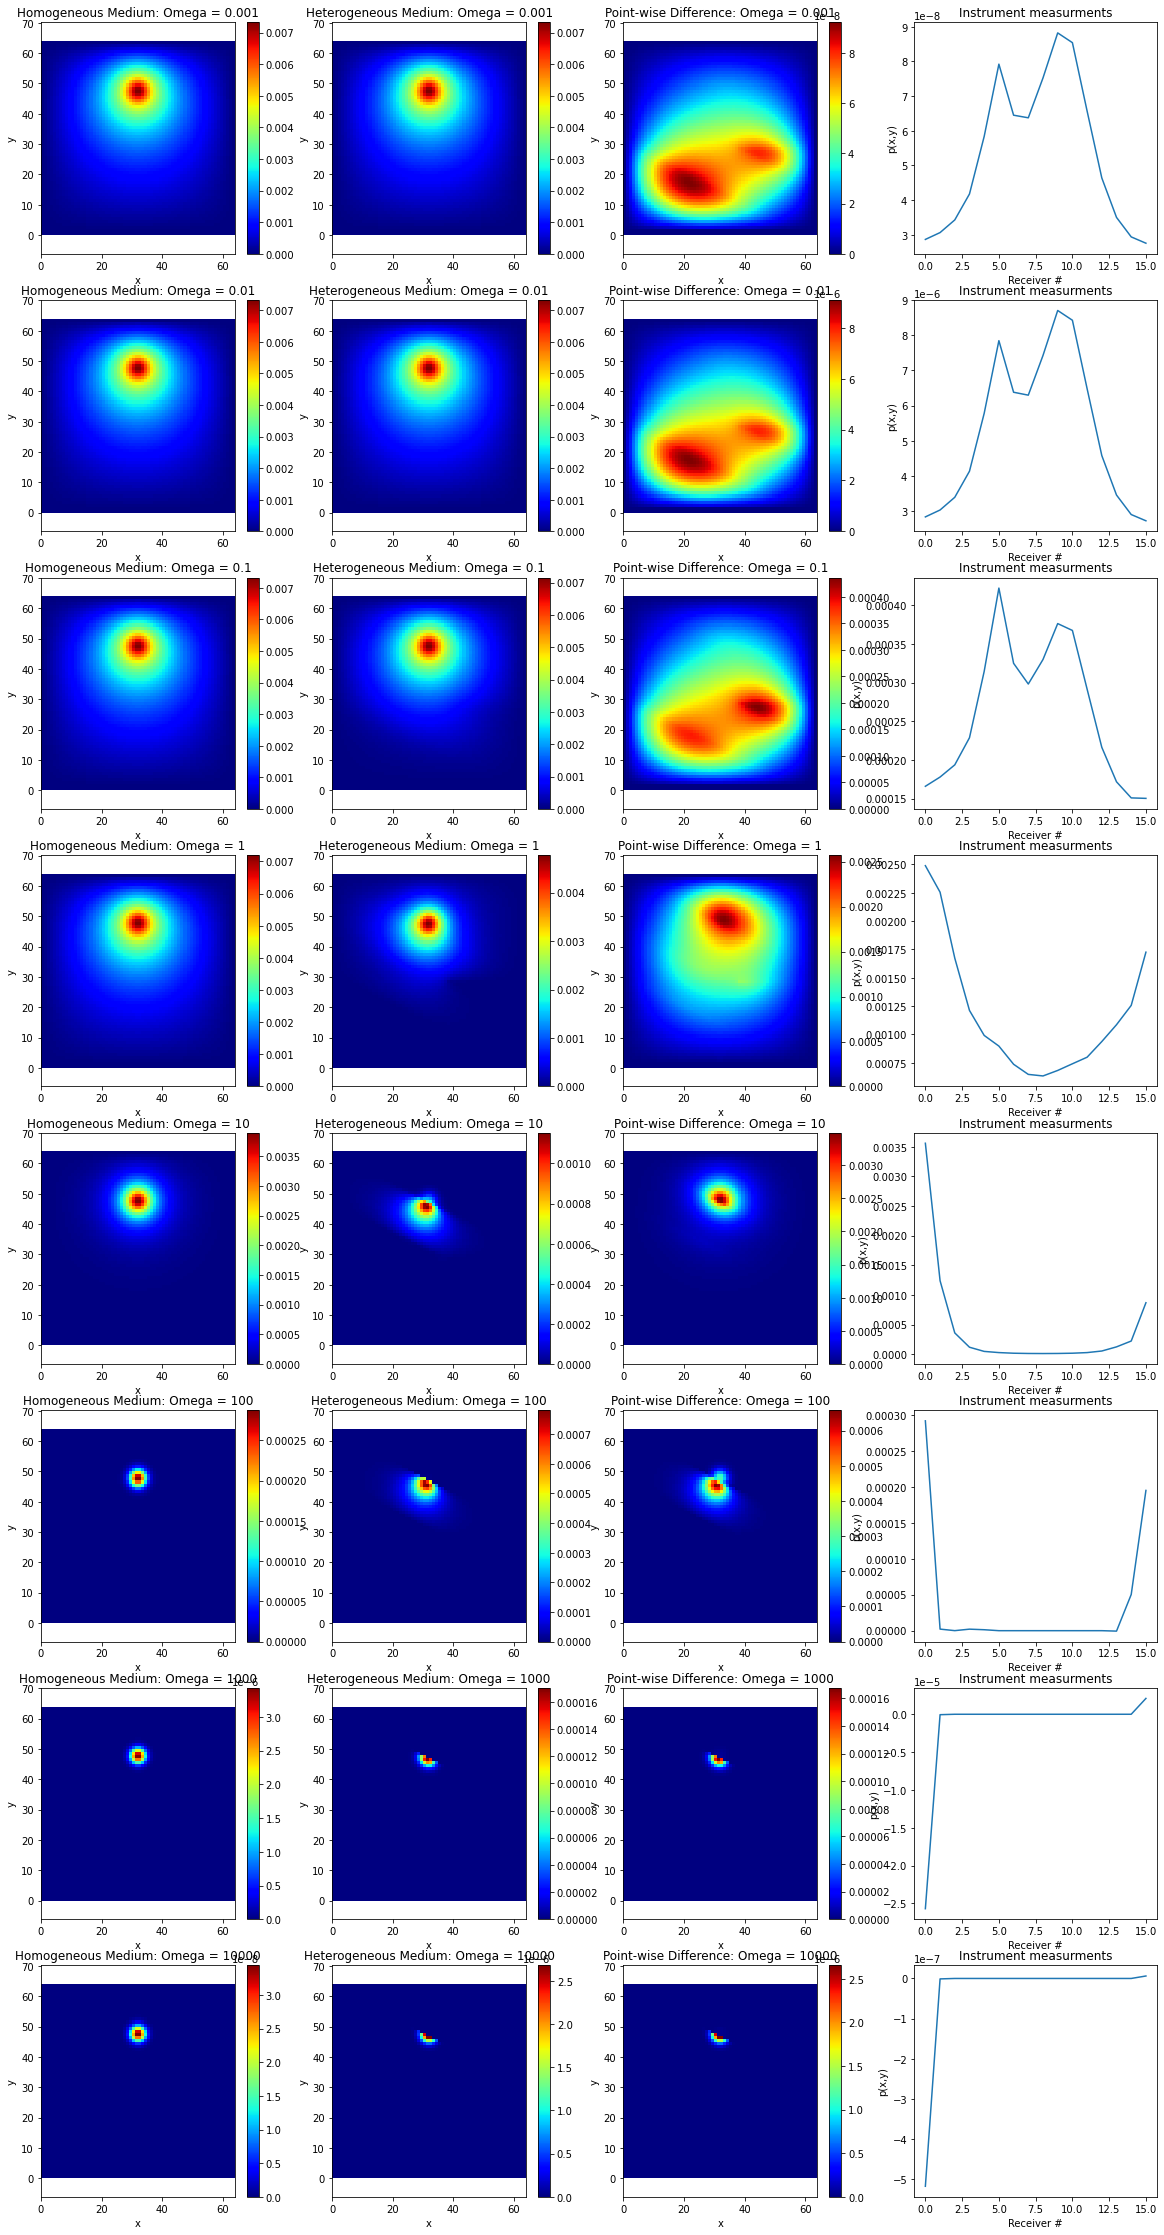

--- 0.20593810081481934 seconds ---
--- 0.2019362449645996 seconds ---
--- 0.2019362449645996 seconds ---
--- 0.2189009189605713 seconds ---
--- 0.20196819305419922 seconds ---
--- 0.20293545722961426 seconds ---
--- 0.2029099464416504 seconds ---
--- 0.23906421661376953 seconds ---
--- 0.20703434944152832 seconds ---
--- 0.22293996810913086 seconds ---
--- 0.20394396781921387 seconds ---
--- 0.20702314376831055 seconds ---
--- 0.20297670364379883 seconds ---
--- 0.20600509643554688 seconds ---
--- 0.23189616203308105 seconds ---
--- 0.20914959907531738 seconds ---
### 4.584704875946045 seconds ###


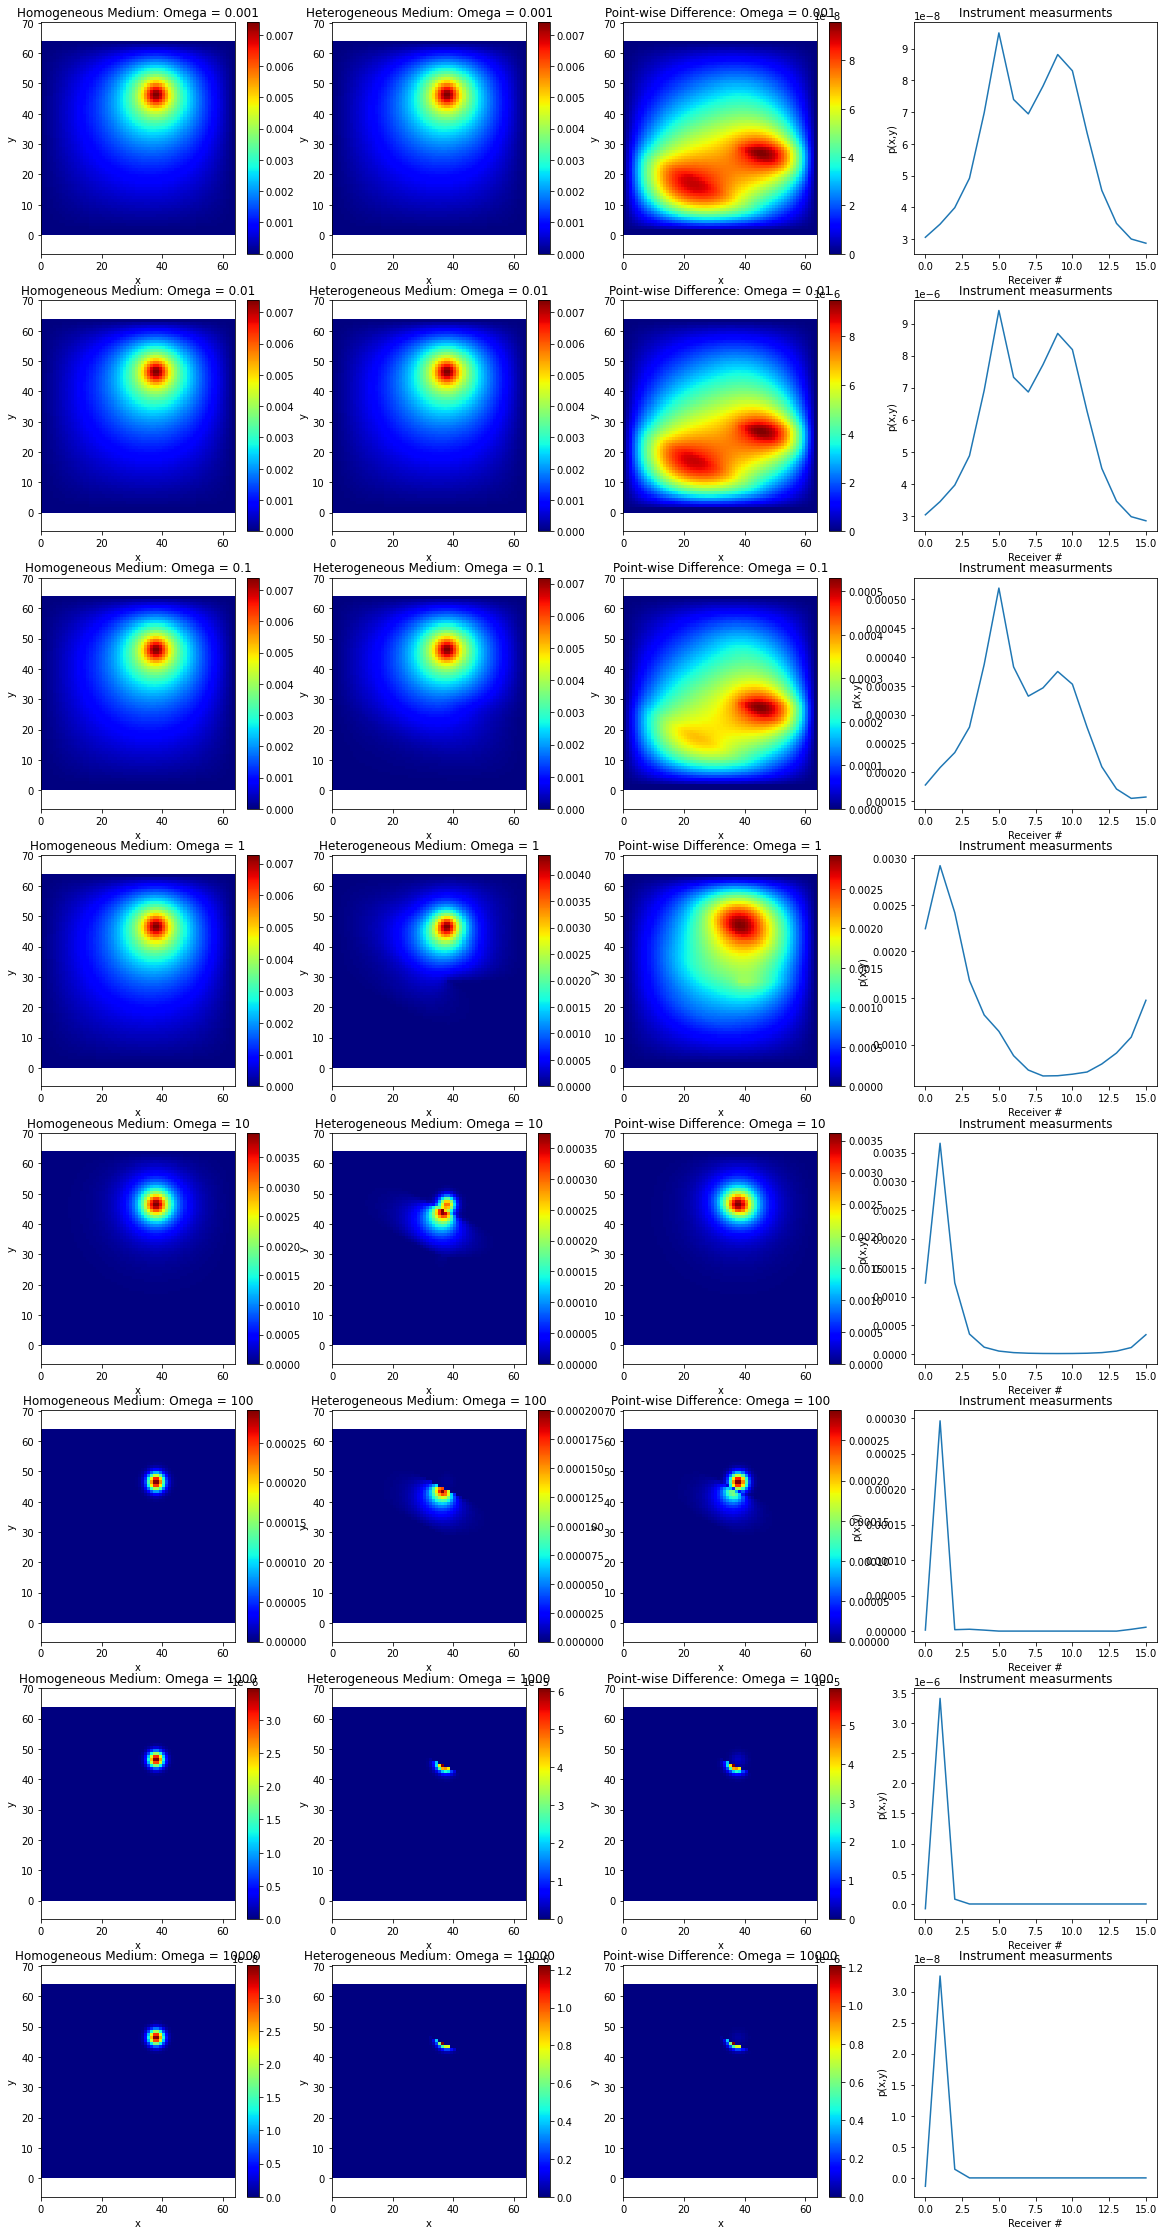

--- 0.23191428184509277 seconds ---
--- 0.2129044532775879 seconds ---
--- 0.19995594024658203 seconds ---
--- 0.2019367218017578 seconds ---
--- 0.20696783065795898 seconds ---
--- 0.21104216575622559 seconds ---
--- 0.22090387344360352 seconds ---
--- 0.2380363941192627 seconds ---
--- 0.22092986106872559 seconds ---
--- 0.20406007766723633 seconds ---
--- 0.20693373680114746 seconds ---
--- 0.20693612098693848 seconds ---
--- 0.2019367218017578 seconds ---
--- 0.2159106731414795 seconds ---
--- 0.22205853462219238 seconds ---
--- 0.20893502235412598 seconds ---
### 4.763330459594727 seconds ###


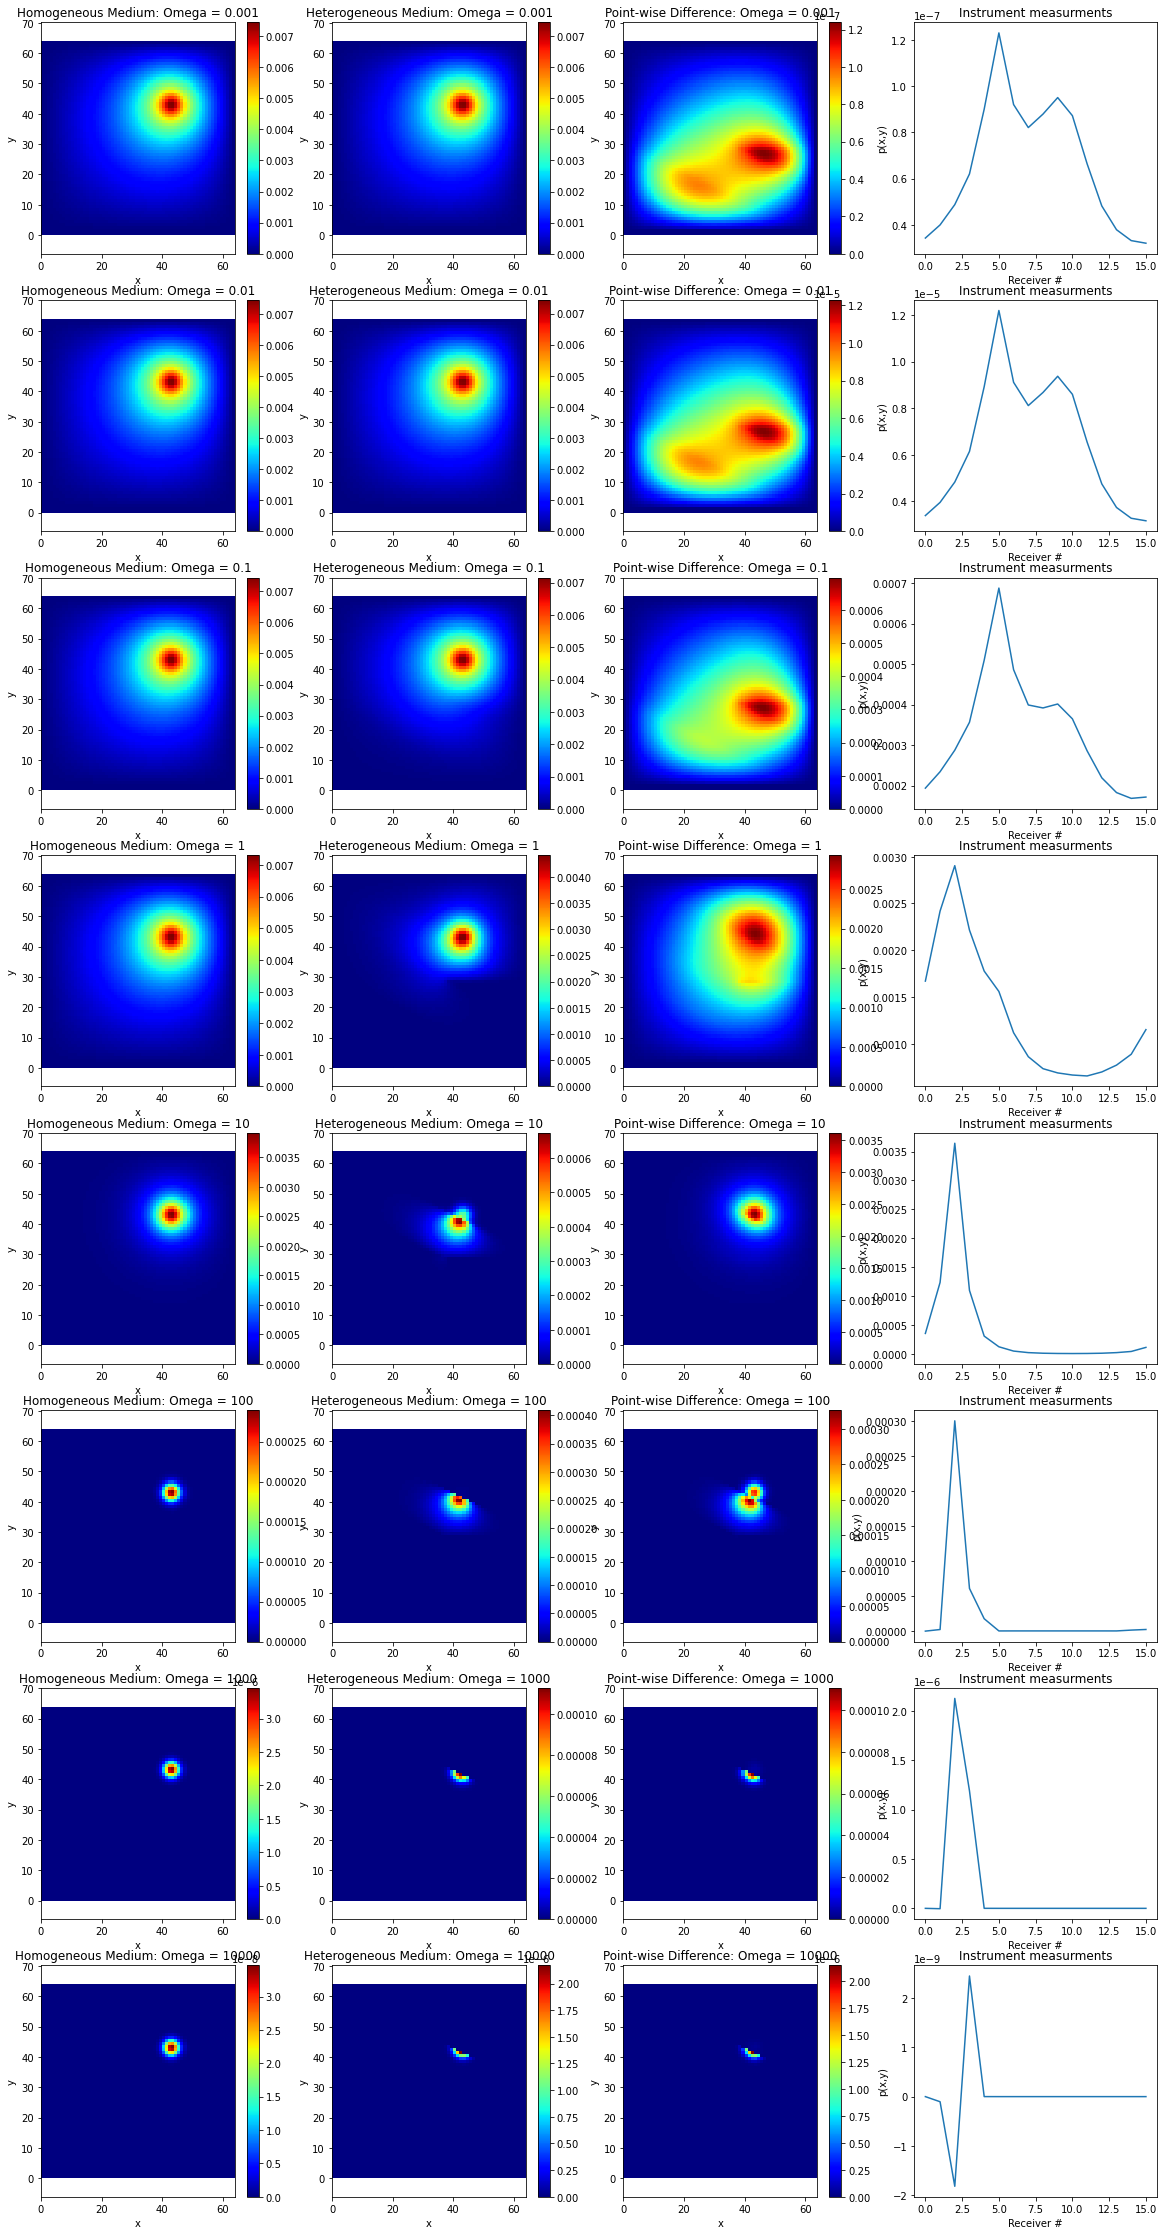

--- 0.22792983055114746 seconds ---
--- 0.2089531421661377 seconds ---
--- 0.21696209907531738 seconds ---
--- 0.22397613525390625 seconds ---
--- 0.20793938636779785 seconds ---
--- 0.2339010238647461 seconds ---
--- 0.28231024742126465 seconds ---
--- 0.23733139038085938 seconds ---
--- 0.25792789459228516 seconds ---
--- 0.22595953941345215 seconds ---
--- 0.23892760276794434 seconds ---
--- 0.29192042350769043 seconds ---
--- 0.25989437103271484 seconds ---
--- 0.2529792785644531 seconds ---
--- 0.3074040412902832 seconds ---
--- 0.22099685668945312 seconds ---
### 5.269040822982788 seconds ###


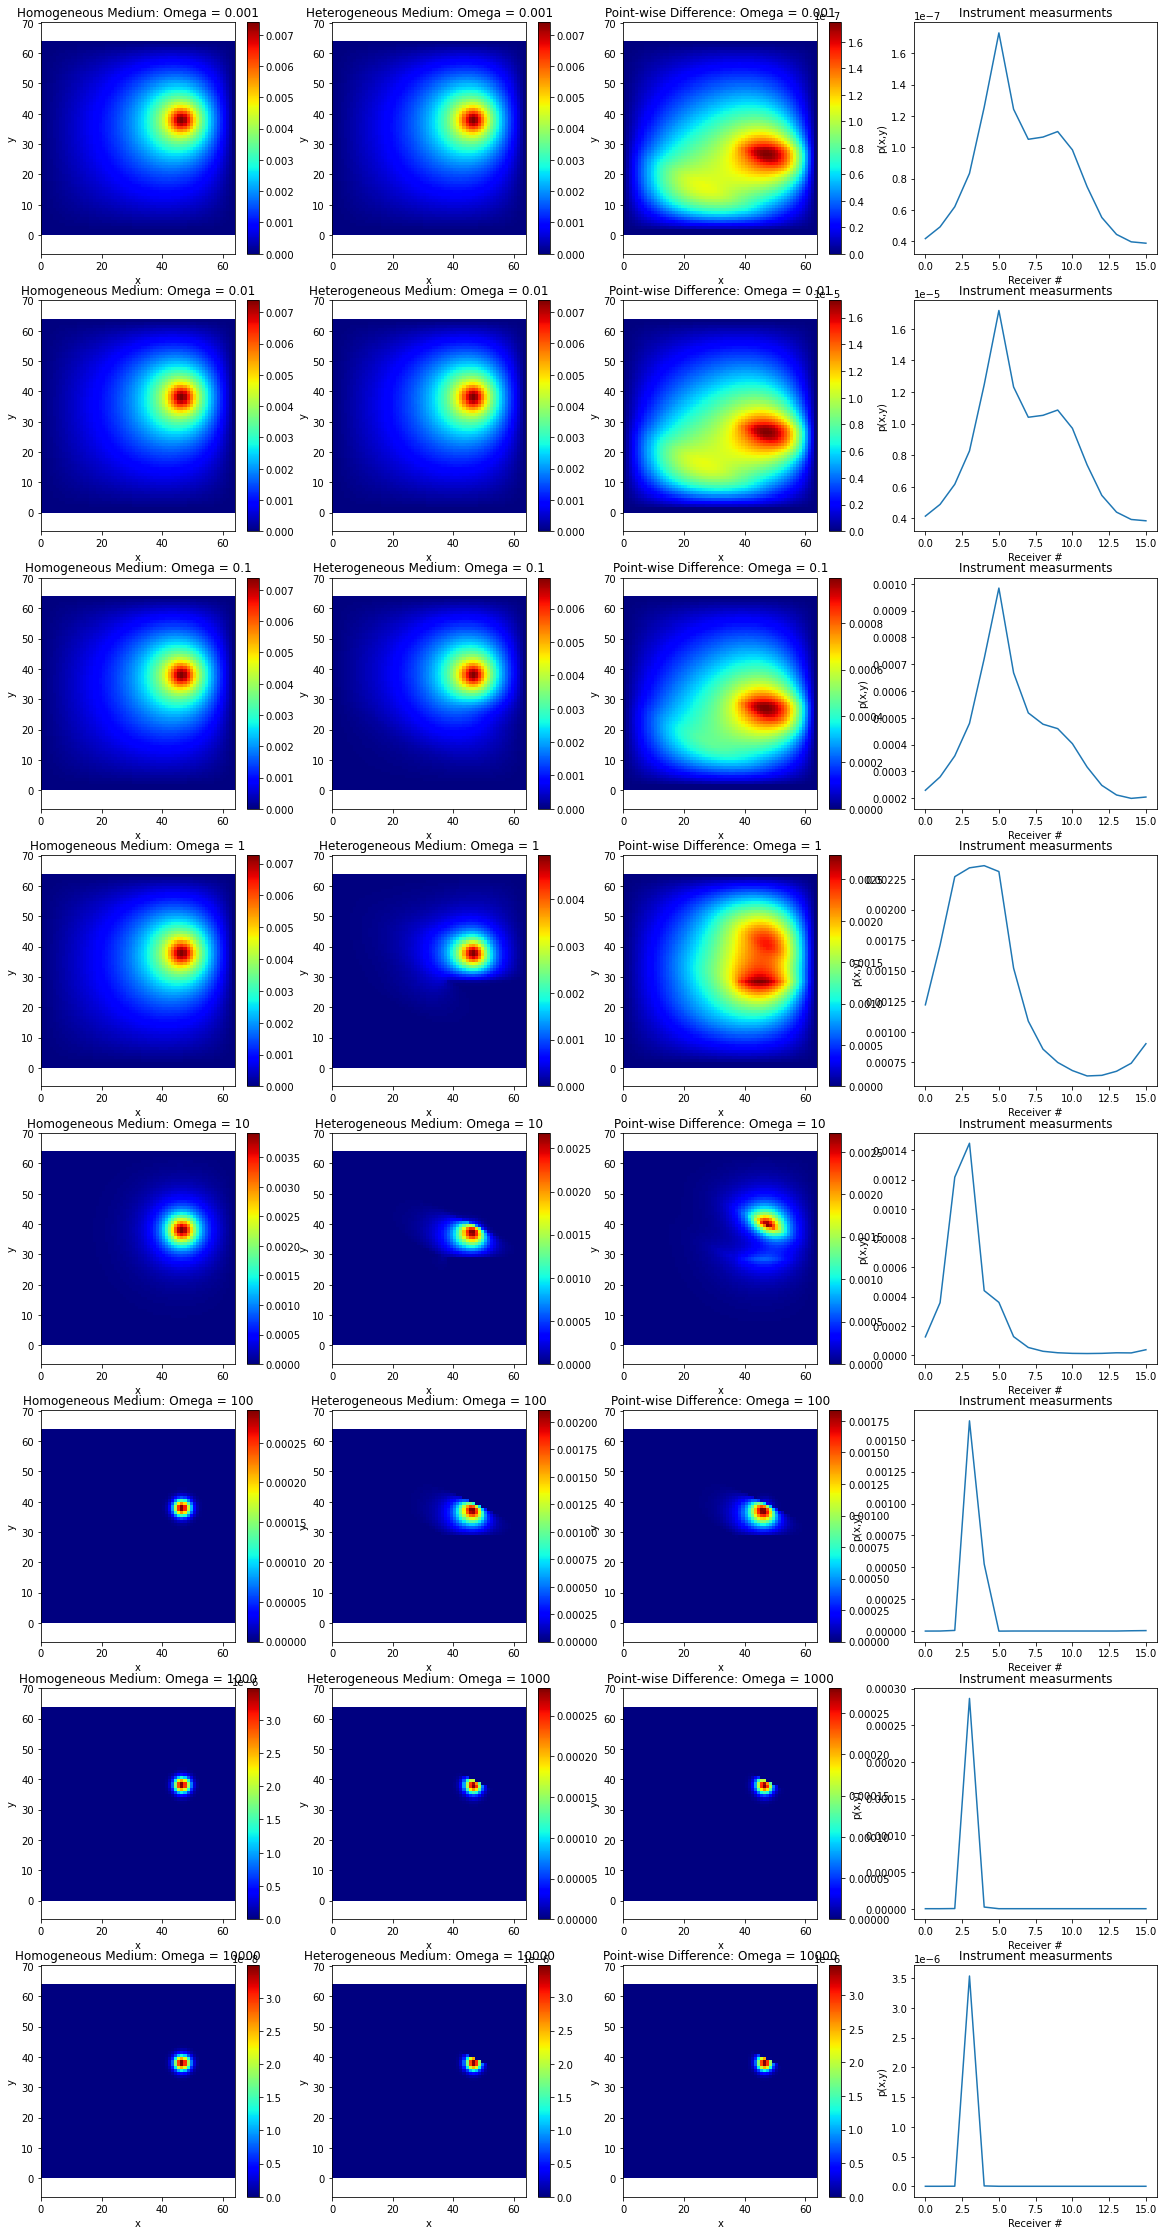

In [36]:
# Initial Conditions
fidelity = 64
# BC's
u_0_x = 0
u_1_x = 0
u_y_0 = 0
u_y_1 = 0
u_dirac = 1
omega_ls = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

omega1 = np.zeros((n, n)); omega2 = np.zeros((n, n)); omega3 = np.zeros((n, n)); omega4 = np.zeros((n, n))
omega5 = np.zeros((n, n)); omega6 = np.zeros((n, n)); omega7 = np.zeros((n, n)); omega8 = np.zeros((n, n))

for j in range(len(z_ls)):
    total_start_time = time.time()
    pressure_init = z_ls[j]
    plt.figure(figsize = [20, len(omega_ls)*5])
    for i in range(len(omega_ls)):
        omega = omega_ls[i]
        waterFlat = 1
        start_time = time.time()
        u_water = helmholtz_solver(fidelity,u_0_x,u_1_x,u_y_0,u_y_1,u_dirac,omega,waterFlat,pressure_init)
        print("--- %s seconds ---" % (time.time() - start_time))

        waterFlat = 0
        start_time = time.time()
        u = helmholtz_solver(fidelity,u_0_x,u_1_x,u_y_0,u_y_1,u_dirac,omega,waterFlat,pressure_init)
        print("--- %s seconds ---" % (time.time() - start_time))

        plt.subplot(len(omega_ls),4,i*4+1)
        plt.pcolormesh(np.flipud(u_water), cmap = 'jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Homogeneous Medium: Omega = ' + str(omega))
        plt.axis('equal')
        plt.colorbar()

        plt.subplot(len(omega_ls),4,i*4+2)
        plt.pcolormesh(np.flipud(u), cmap = 'jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Heterogeneous Medium: Omega = ' + str(omega))
        plt.axis('equal')
        plt.colorbar()

        plt.subplot(len(omega_ls),4,i*4+3)
        plt.pcolormesh(np.flipud(abs(u-u_water)), cmap = 'jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Point-wise Difference: Omega = ' + str(omega))
        plt.axis('equal')
        plt.colorbar()

        plt.subplot(len(omega_ls),4,i*4+4)
        x = np.linspace(0, 1, size)
        y = np.linspace(0, 1, size)
        interp= scipy.interpolate.RegularGridInterpolator((x,y), np.flipud(abs(u-u_water)), method='cubic')
        receiver = interp((circle[:,0], circle[:,1]))
        plt.plot(receiver)
        plt.title('Instrument measurments')
        plt.xlabel('Receiver #')
        plt.ylabel('p(x,y)')
        
        if i == 0:
            omega1[j,:] = receiver
        elif i == 1:
            omega2[j,:] = receiver
        elif i == 2:
            omega3[j,:] = receiver
        elif i == 3:
            omega4[j,:] = receiver
        elif i == 4:
            omega5[j,:] = receiver
        elif i == 5:
            omega6[j,:] = receiver
        elif i == 6:
            omega7[j,:] = receiver
        elif i == 7:
            omega8[j,:] = receiver
            
            
    print("### %s seconds ###" % (time.time() - total_start_time))    
    #plt.savefig('testing', dpi = 300)
    plt.show()

In [61]:
vmin = 10000
vmax = -10000
vmin = min(min([[vmin],omega1.flatten().tolist()]))
vmin = min(min([[vmin],omega2.flatten().tolist()]))
vmin = min(min([[vmin],omega3.flatten().tolist()]))
vmin = min(min([[vmin],omega4.flatten().tolist()]))
vmin = min(min([[vmin],omega5.flatten().tolist()]))
vmin = min(min([[vmin],omega6.flatten().tolist()]))
vmin = min(min([[vmin],omega7.flatten().tolist()]))
vmin = min(min([[vmin],omega8.flatten().tolist()]))
vmax = max(max([[vmax],omega1.flatten().tolist()]))
vmax = max(max([[vmax],omega2.flatten().tolist()]))
vmax = max(max([[vmax],omega3.flatten().tolist()]))
vmax = max(max([[vmax],omega4.flatten().tolist()]))
vmax = max(max([[vmax],omega5.flatten().tolist()]))
vmax = max(max([[vmax],omega6.flatten().tolist()]))
vmax = max(max([[vmax],omega7.flatten().tolist()]))
vmax = max(max([[vmax],omega8.flatten().tolist()]))

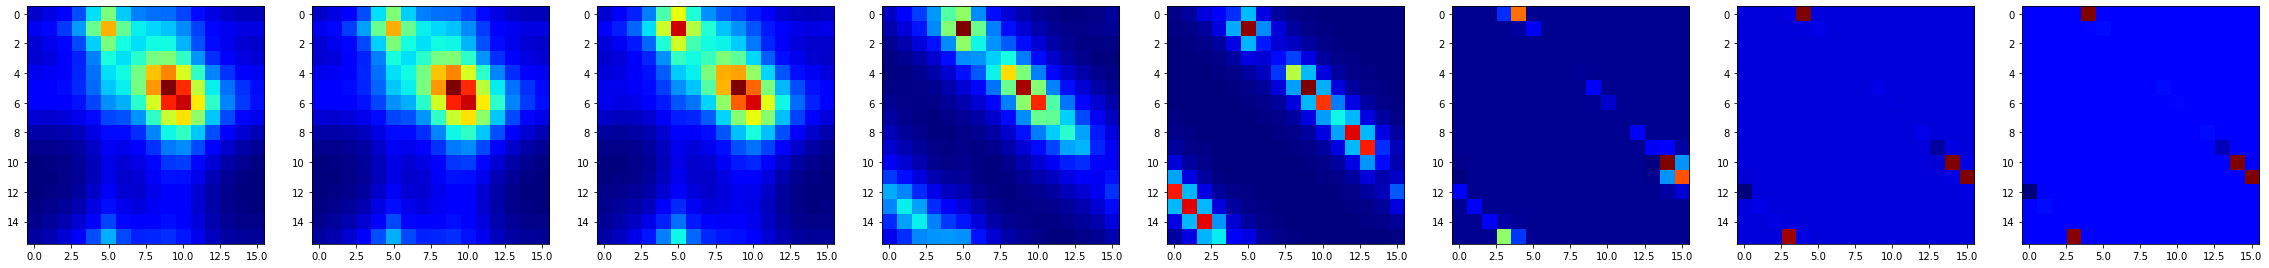

In [64]:
cmap = 'jet'
plt.figure(figsize = [40, 5])
plt.subplot(1,8,1)
plt.imshow(omega1, cmap = cmap)
plt.subplot(1,8,2)
plt.imshow(omega2, cmap = cmap)
plt.subplot(1,8,3)
plt.imshow(omega3, cmap = cmap)
plt.subplot(1,8,4)
plt.imshow(omega4, cmap = cmap)
plt.subplot(1,8,5)
plt.imshow(omega5, cmap = cmap)
plt.subplot(1,8,6)
plt.imshow(omega6, cmap = cmap)
plt.subplot(1,8,7)
plt.imshow(omega7, cmap = cmap)
plt.subplot(1,8,8)
plt.imshow(omega8, cmap = cmap)

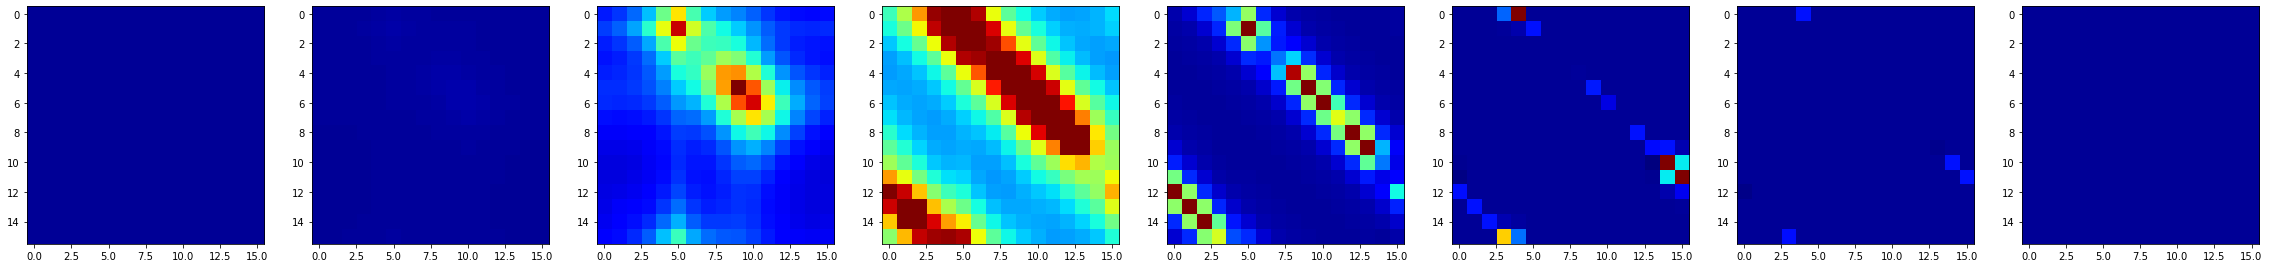

In [63]:
cmap = 'jet'
plt.figure(figsize = [40, 5])
plt.subplot(1,8,1)
plt.imshow(omega1, cmap = cmap, vmin = vmin, vmax = vmax)
plt.subplot(1,8,2)
plt.imshow(omega2, cmap = cmap, vmin = vmin, vmax = vmax)
plt.subplot(1,8,3)
plt.imshow(omega3, cmap = cmap, vmin = vmin, vmax = vmax)
plt.subplot(1,8,4)
plt.imshow(omega4, cmap = cmap, vmin = vmin, vmax = vmax)
plt.subplot(1,8,5)
plt.imshow(omega5, cmap = cmap, vmin = vmin, vmax = vmax)
plt.subplot(1,8,6)
plt.imshow(omega6, cmap = cmap, vmin = vmin, vmax = vmax)
plt.subplot(1,8,7)
plt.imshow(omega7, cmap = cmap, vmin = vmin, vmax = vmax)
plt.subplot(1,8,8)
plt.imshow(omega8, cmap = cmap, vmin = vmin, vmax = vmax)